# Importing library and metadata

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

from sklearn.decomposition import IncrementalPCA, MiniBatchNMF

import random
import pickle
import pydicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display
import cv2

import data_splitter as ds
import data_loader as dl
import feature_extraction as fex
import run_model as rm
import eval_model as ev

2023-04-18 05:48:21.503086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 05:48:22.486665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
metadata = pd.read_csv('train.csv')
metadata.head()

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

In [4]:
print('Total image file: ', metadata.image_id.nunique())
print('Total patient id: ', metadata.patient_id.nunique())
print('Mean image per patient: ', (metadata.image_id.nunique()/metadata.patient_id.nunique()))

Total image file:  54706
Total patient id:  11913
Mean image per patient:  4.592126248635944


# Getting the training set

In [5]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  8100
Total patient_id in calibration set:  1430
Total image_id in training set:  37219
Total image_id in calibration set:  6548


In [6]:
set(splitter.train.keys()).intersection(set(splitter.test.keys()))

set()

In [7]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()

In [8]:
# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6480
----Total image_id in training set:  29718
----Total patient_id in validation set:  1620
----Total image_id in validation set:  7501
--Fold:  1
----Total patient_id in training set:  6480
----Total image_id in training set:  29758
----Total patient_id in validation set:  1620
----Total image_id in validation set:  7461
--Fold:  2
----Total patient_id in training set:  6480
----Total image_id in training set:  29670
----Total patient_id in validation set:  1620
----Total image_id in validation set:  7549
--Fold:  3
----Total patient_id in training set:  6480
----Total image_id in training set:  29887
----Total patient_id in validation set:  1620
----Total image_id in validation set:  7332
--Fold:  4
----Total patient_id in training set:  6480
----Total image_id in training set:  29843
----Total patient_id in validation set:  1620
----Total image_id in validation set:  7376


In [13]:
for fold in cv_img:
    train = metadata[metadata.image_id.isin(cv_img[fold]['train'])]
    val = metadata[metadata.image_id.isin(cv_img[fold]['validate'])]
    
    print('Total positive cases in train split: {} patients {} images'.format(train[train.cancer==1].patient_id.nunique(), train[train.cancer==1].image_id.nunique()))
    print('Total negative cases in train split: {} patients {} images'.format(train[train.cancer==0].patient_id.nunique(), train[train.cancer==0].image_id.nunique()))
    
    print('Total positive cases in validation split: {} patients {} images'.format(val[val.cancer==1].patient_id.nunique(), val[val.cancer==1].image_id.nunique()))
    print('Total negative cases in validation split: {} patients {} images'.format(val[val.cancer==0].patient_id.nunique(), val[val.cancer==0].image_id.nunique()))
    print('')

Total positive cases in train split: 265 patients 622 images
Total negative cases in train split: 6479 patients 29096 images
Total positive cases in validation split: 66 patients 155 images
Total negative cases in validation split: 1619 patients 7346 images

Total positive cases in train split: 265 patients 619 images
Total negative cases in train split: 6479 patients 29139 images
Total positive cases in validation split: 66 patients 158 images
Total negative cases in validation split: 1619 patients 7303 images

Total positive cases in train split: 265 patients 617 images
Total negative cases in train split: 6478 patients 29053 images
Total positive cases in validation split: 66 patients 160 images
Total negative cases in validation split: 1620 patients 7389 images

Total positive cases in train split: 265 patients 626 images
Total negative cases in train split: 6478 patients 29261 images
Total positive cases in validation split: 66 patients 151 images
Total negative cases in validatio

## Sample only 40 patients data (1 images per patient)

In [68]:
train_meta = metadata[metadata.patient_id.isin(splitter.trainset.keys())]

cancer_by_patient = train_meta.groupby('patient_id')['cancer'].sum().reset_index()

random.seed(42)

cancer_patient_ids = random.sample(list(cancer_by_patient[cancer_by_patient.cancer>0].patient_id.unique()), k=20)
cancer_img_ids =  [random.sample(list(train_meta[(train_meta.patient_id==patient_id)&(train_meta.cancer==1)].image_id.unique()), k=1)[0] for patient_id in cancer_patient_ids]

no_cancer_patient_ids = random.sample(list(cancer_by_patient[cancer_by_patient.cancer==0].patient_id.unique()), k=20)
no_cancer_img_ids =  [random.sample(list(train_meta[train_meta.patient_id==patient_id].image_id.unique()), k=1)[0] for patient_id in no_cancer_patient_ids]

sample_img_ids = [*cancer_img_ids, *no_cancer_img_ids]

sample_meta = metadata[metadata.image_id.isin(sample_img_ids)]
sample_meta.head()

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
569         1       10589   195400299          L  MLO  74.0       1       1   
1311        2       11365   199041775          L  MLO  54.0       1       1   
3678        1       13920  1998384452          R  MLO  81.0       1       1   
3870        1       14162   648759642          L  MLO  58.0       0       1   
8660        2       19289    14659818          L  MLO  70.0       0       0   

      invasive  BIRADS  implant density  machine_id  difficult_negative_case  
569          1     0.0        0       B         170                    False  
1311         0     NaN        0     NaN          21                    False  
3678         0     0.0        0       C          49                    False  
3870         0     0.0        0       B          49                     True  
8660         0     NaN        0     NaN          48                    False

In [69]:
sample_splitter = ds.DataSplitter(sample_meta, verbose=True)

Total patient_id in training set:  32
Total patient_id in test set:  8
Total image_id in training set:  32
Total image_id in test set:  8
Total patient_id in training set:  25
Total patient_id in calibration set:  7
Total image_id in training set:  25
Total image_id in calibration set:  7


In [70]:
# getting cross-validation folds
RANDOM_STATE = 42
sample_cv_patient, sample_cv_img = sample_splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  20
----Total image_id in training set:  20
----Total patient_id in validation set:  5
----Total image_id in validation set:  5
--Fold:  1
----Total patient_id in training set:  20
----Total image_id in training set:  20
----Total patient_id in validation set:  5
----Total image_id in validation set:  5
--Fold:  2
----Total patient_id in training set:  20
----Total image_id in training set:  20
----Total patient_id in validation set:  5
----Total image_id in validation set:  5
--Fold:  3
----Total patient_id in training set:  20
----Total image_id in training set:  20
----Total patient_id in validation set:  5
----Total image_id in validation set:  5
--Fold:  4
----Total patient_id in training set:  20
----Total image_id in training set:  20
----Total patient_id in validation set:  5
----Total image_id in validation set:  5


# Image preprocessing

## Example of mammogram DICOM image

In [12]:
dcm = pydicom.dcmread('/scratch/siads699w23_class_root/siads699w23_class/shared_data/team_mammogram/train_images/11799/776011358.dcm')
print(dcm)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.11799.1.776011358
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.11799.1.776011358
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184059.355243'
(0010, 0020) Patient ID                          LO: '11799'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.11799
(0020, 000e) Series Instance U

In [13]:
print(dcm.file_meta)

(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.11799.1.776011358
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'


(4096, 3328)
uint16


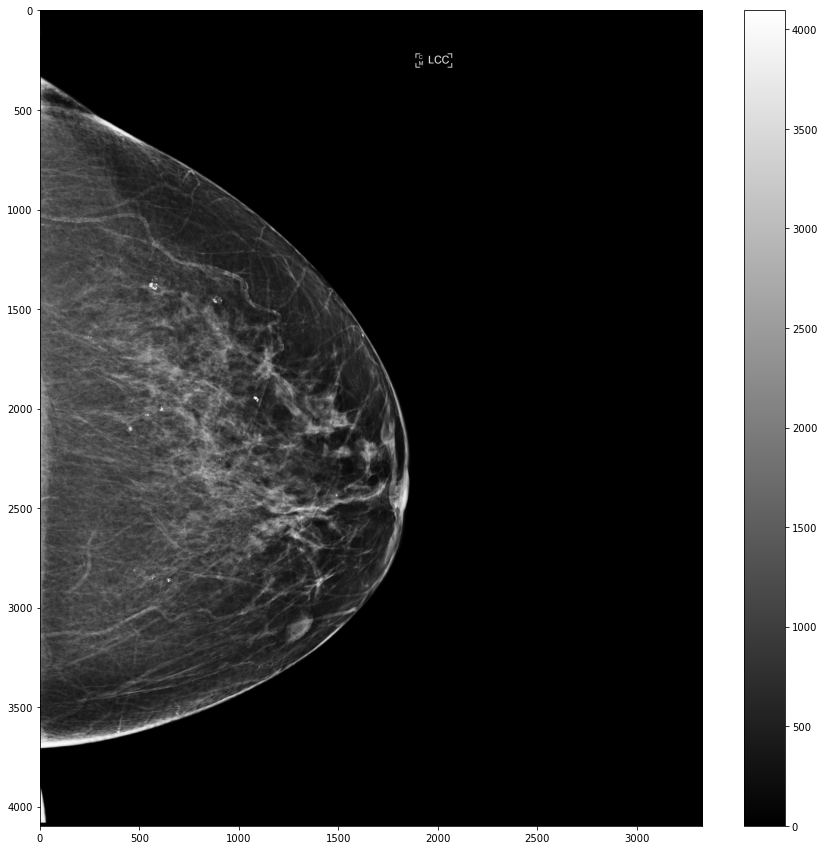

In [14]:
print(dcm.pixel_array.shape)
print(dcm.pixel_array.dtype)

fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(dcm.pixel_array, cmap='gray')

plt.colorbar()
plt.show()

## Before and after preprocessing

/home/irinb/eval_model.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


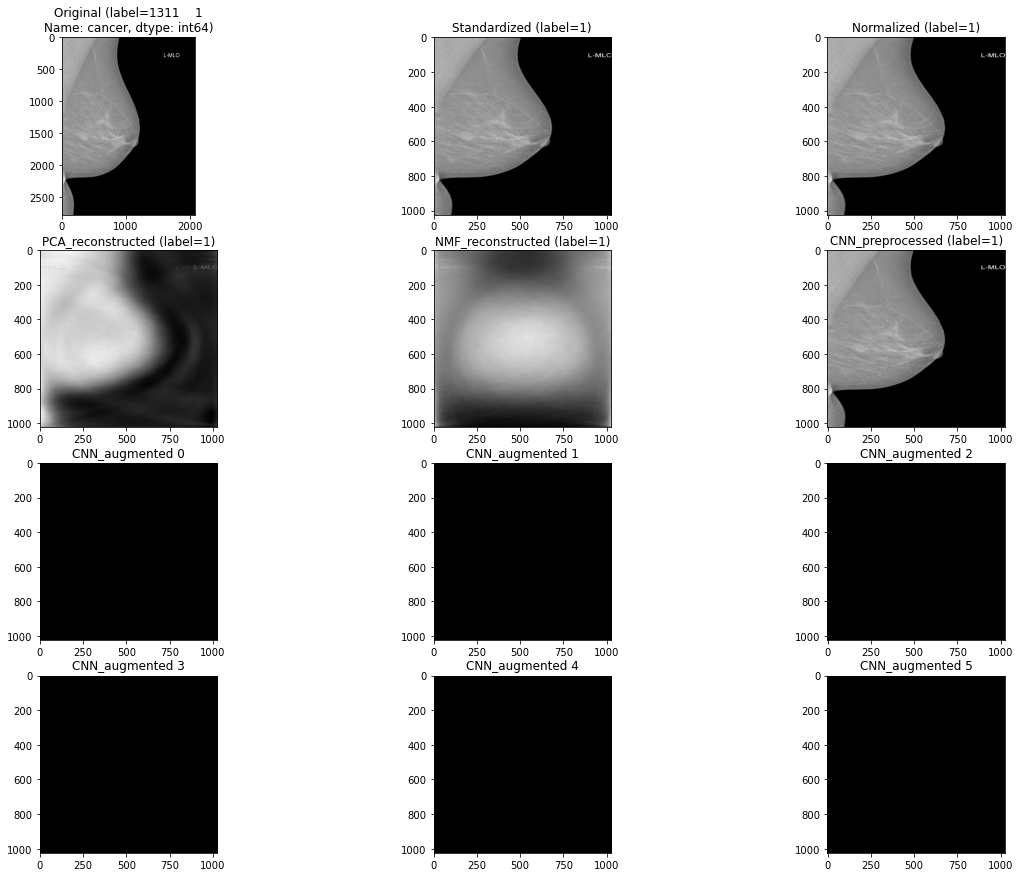

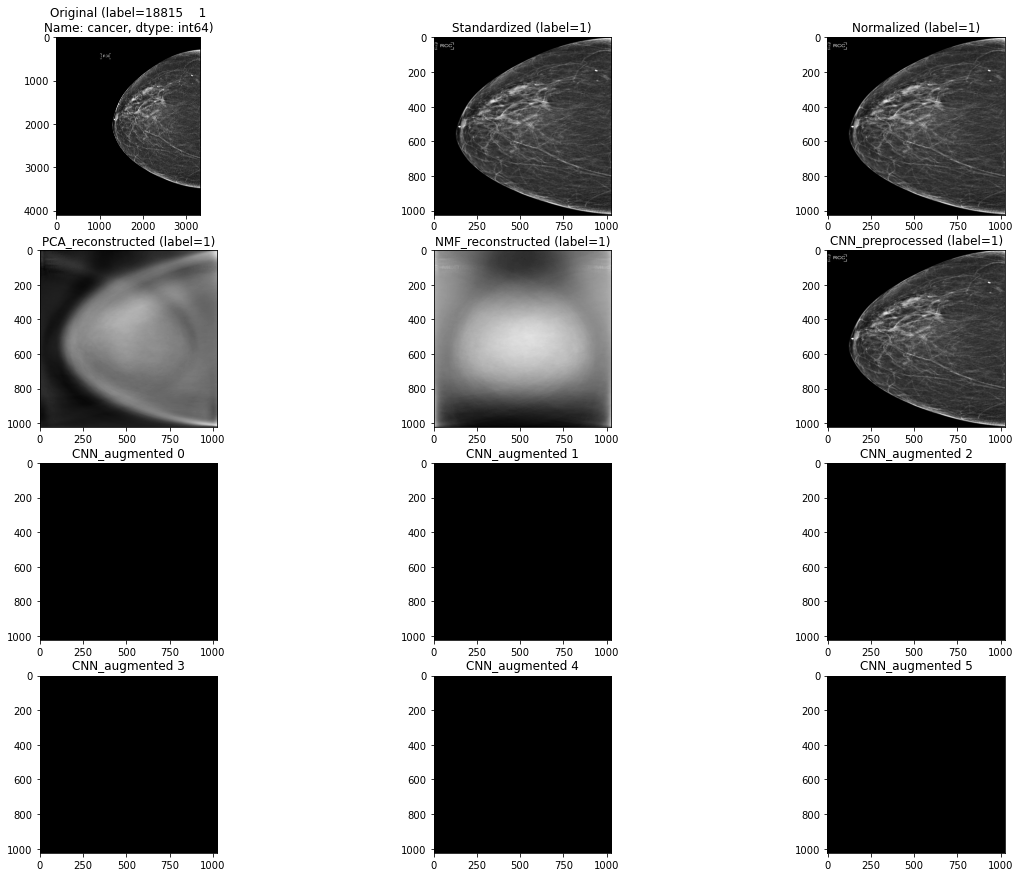

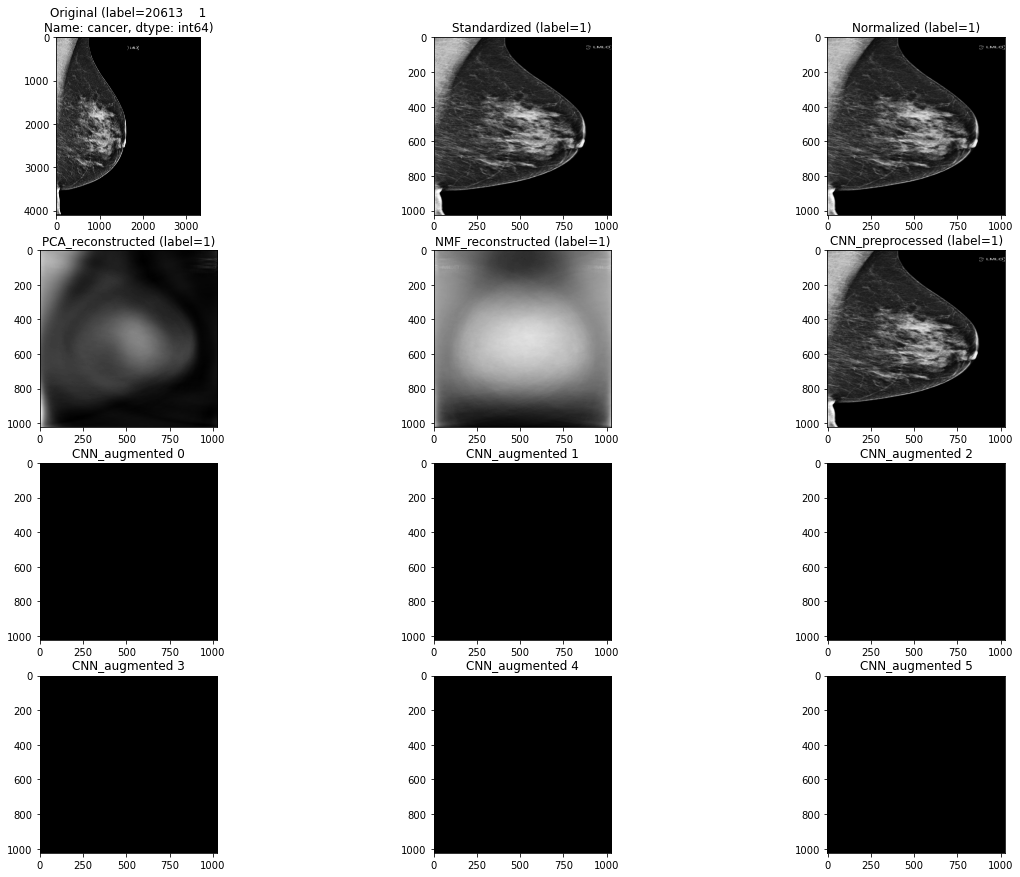

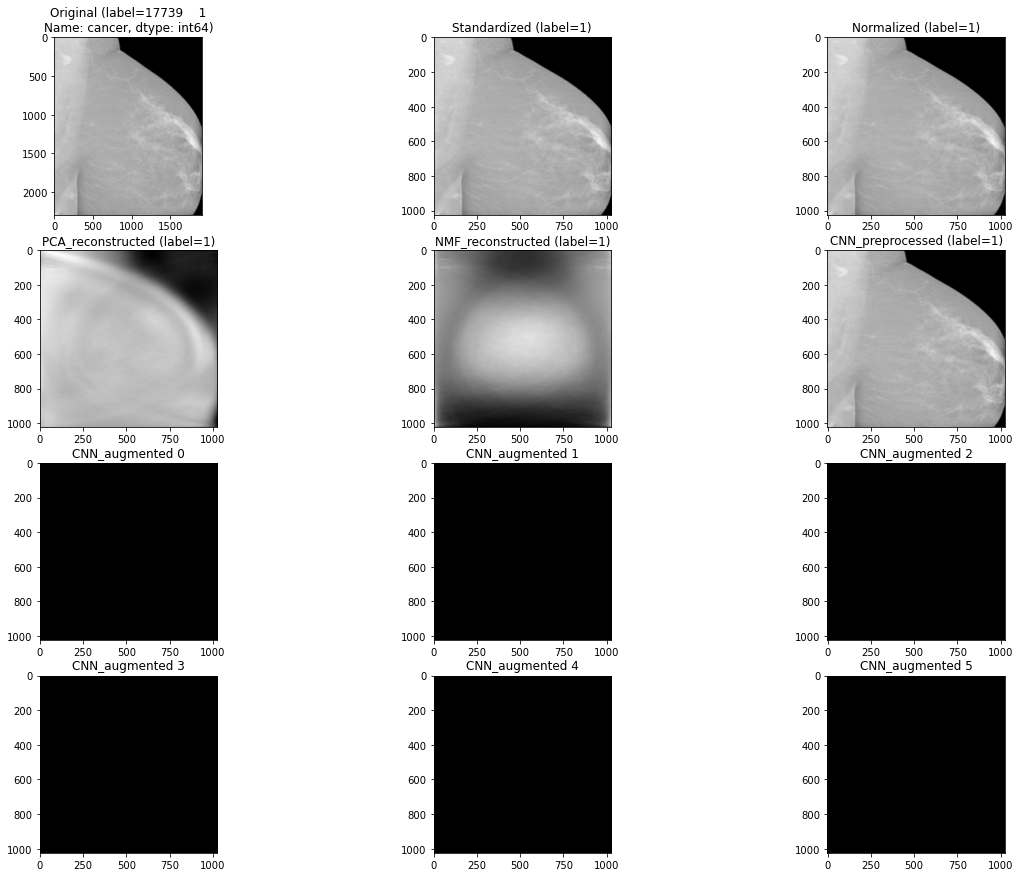

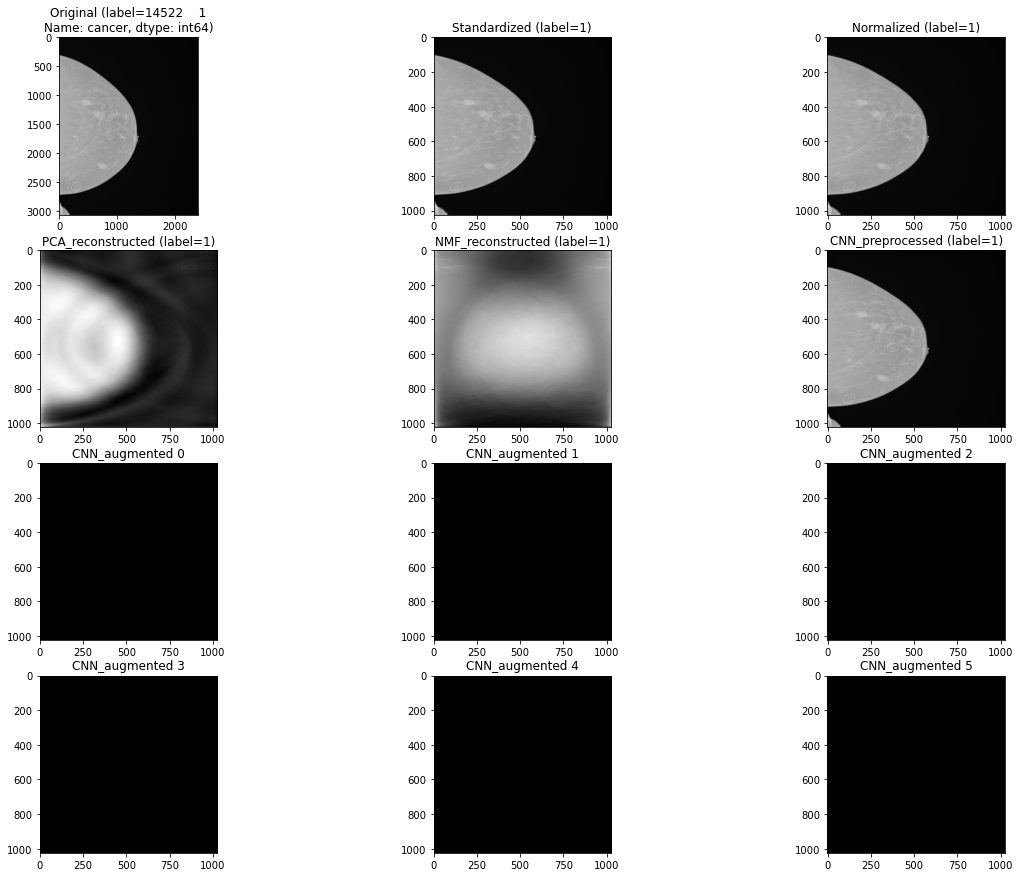

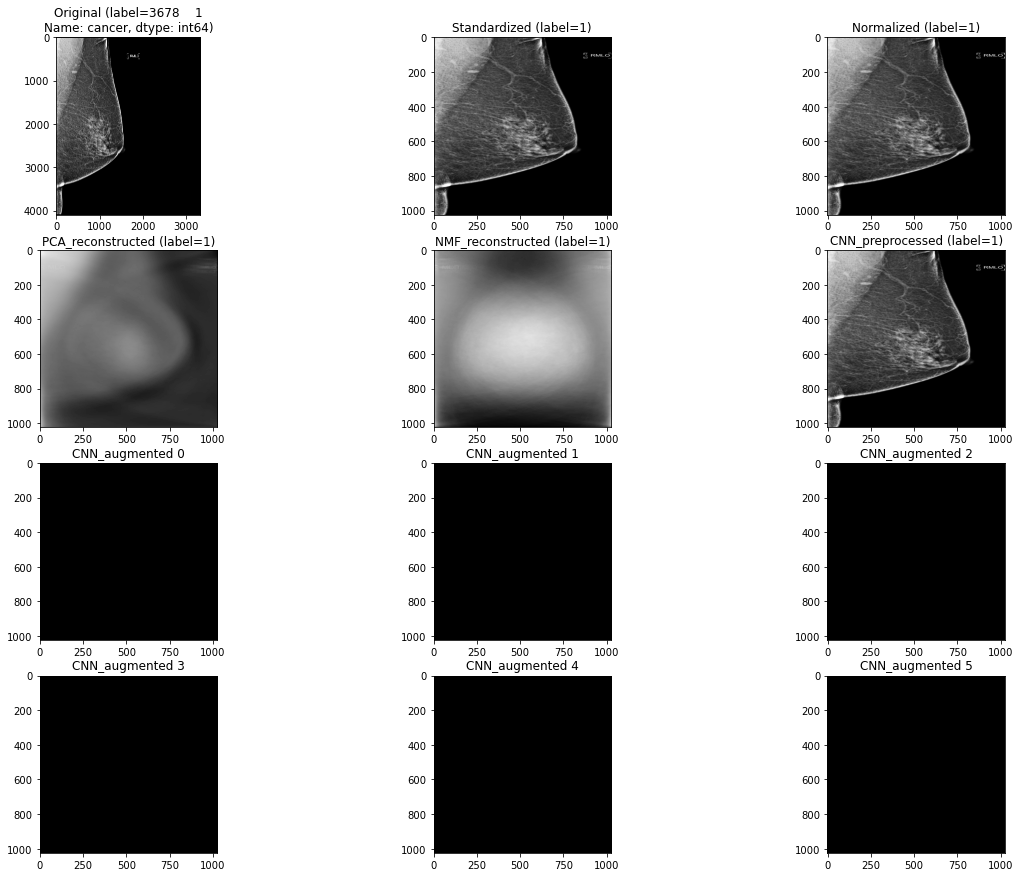

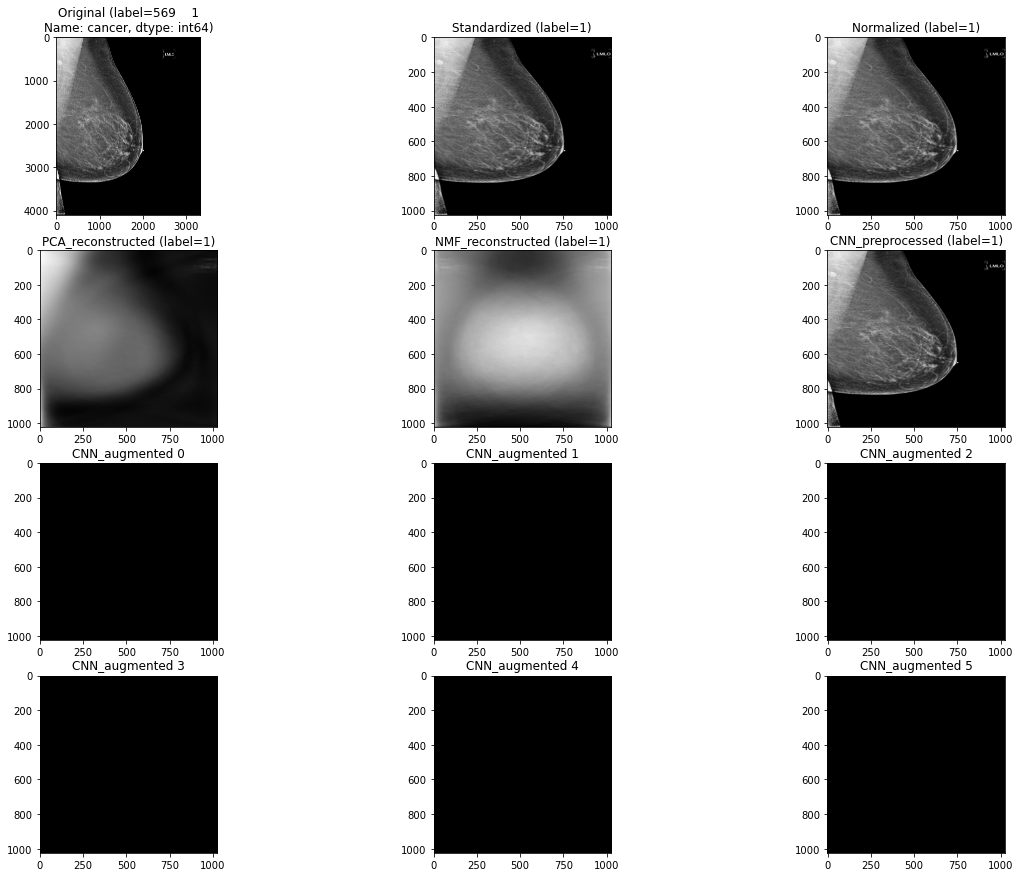

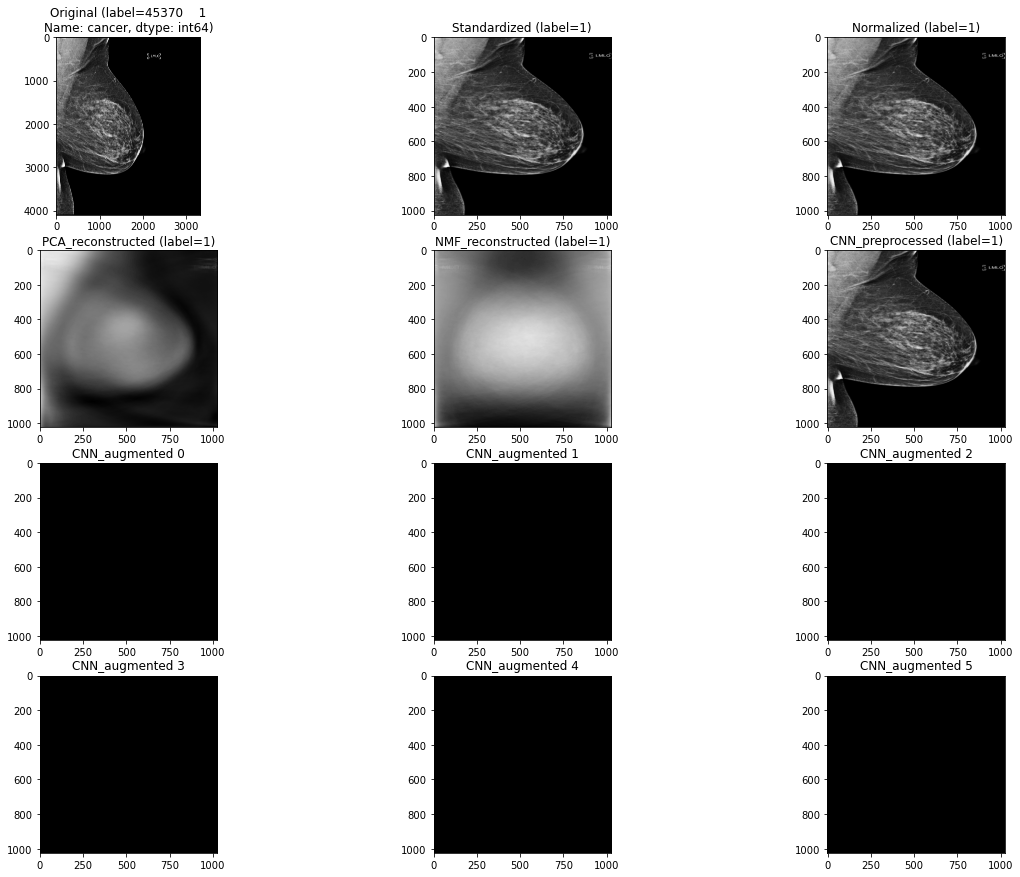

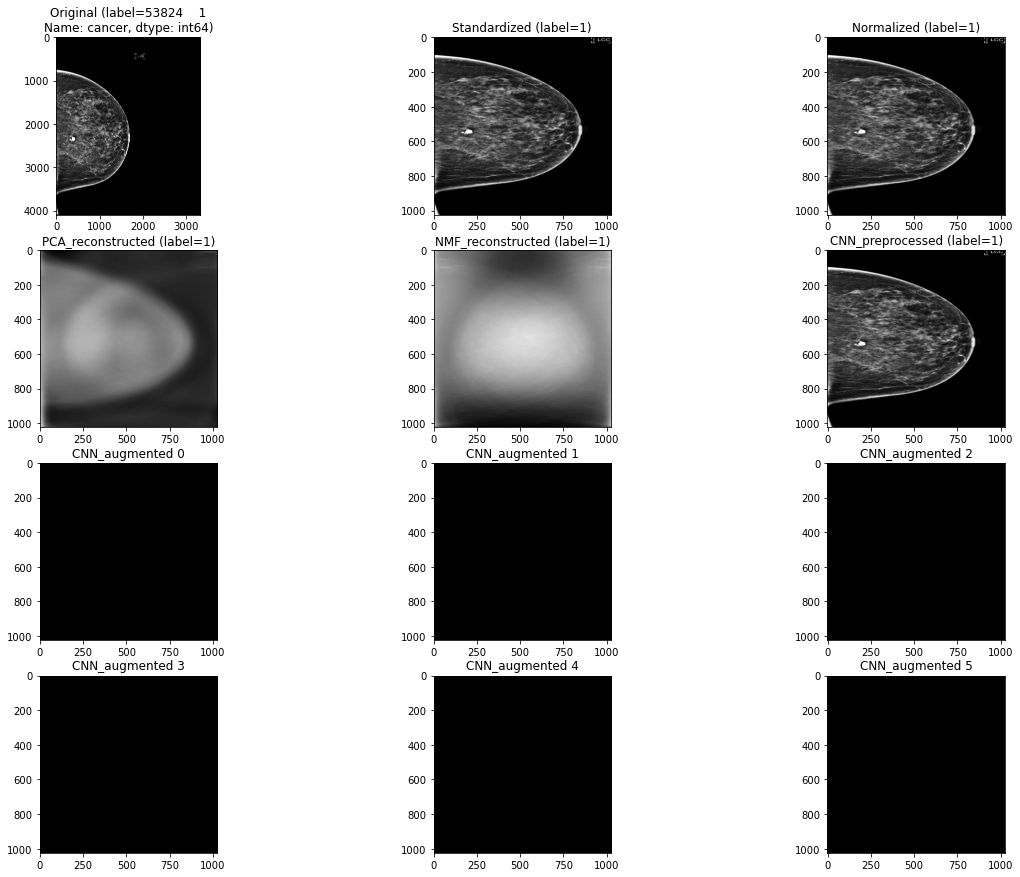

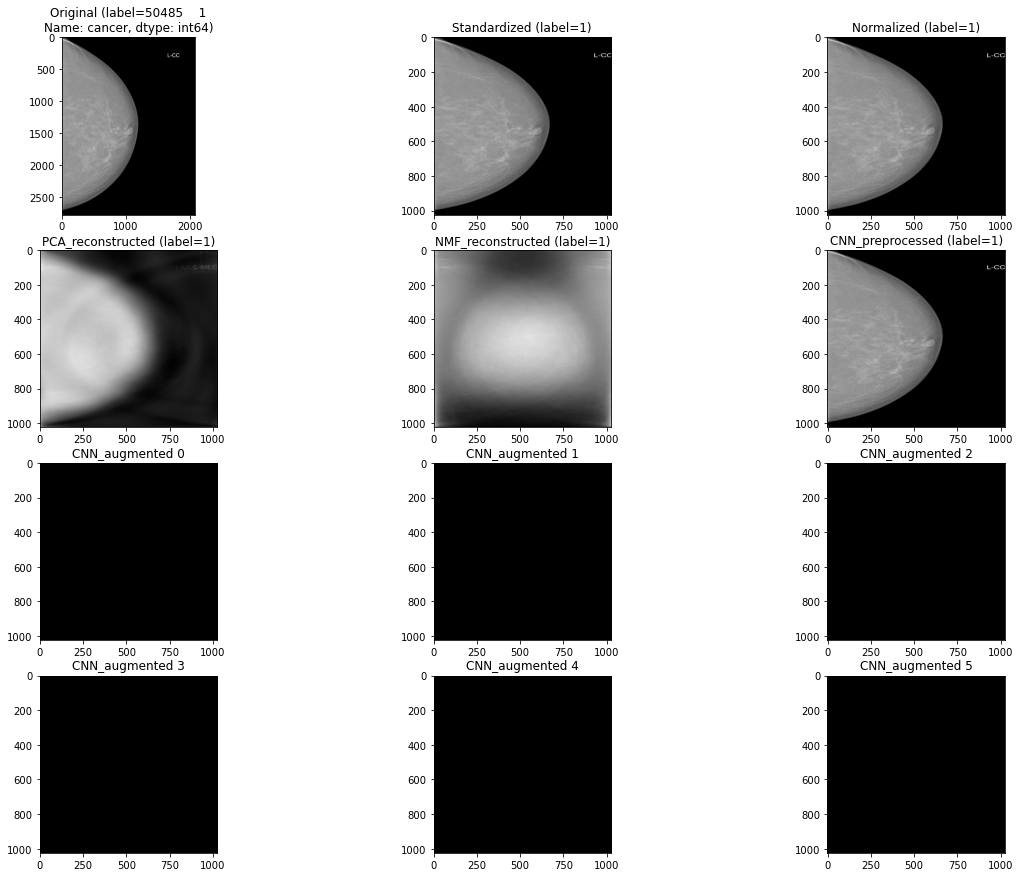

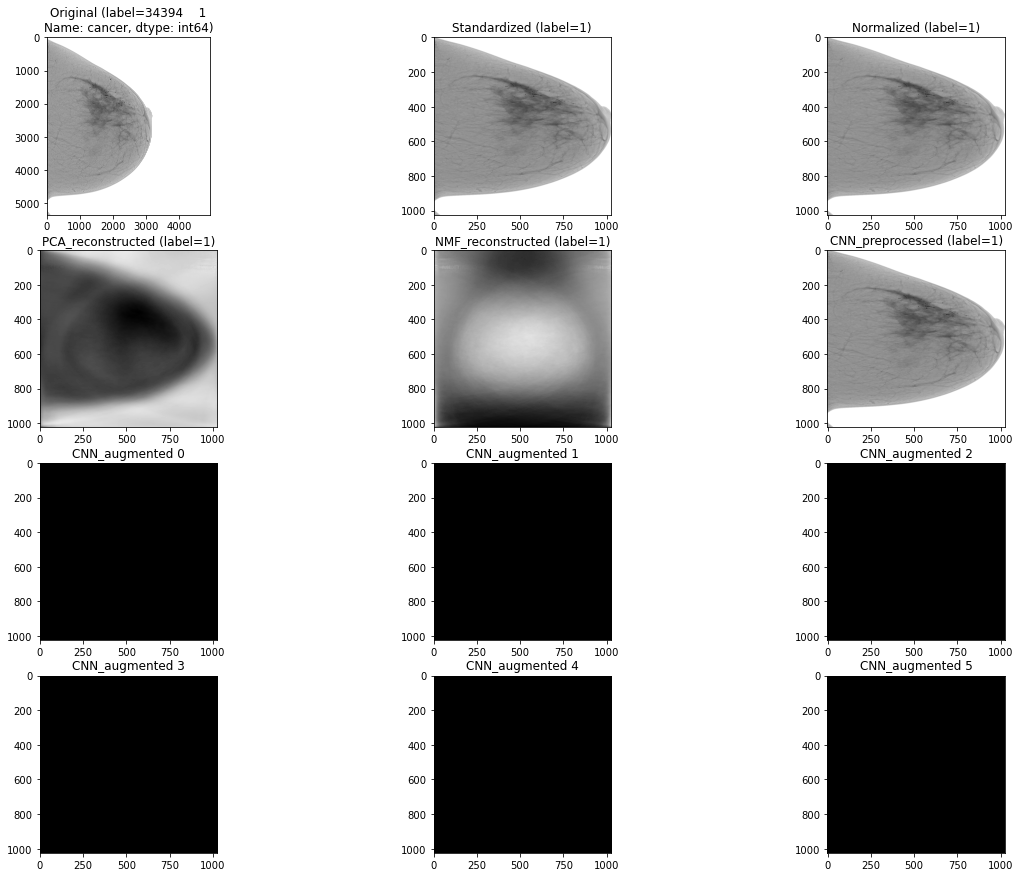

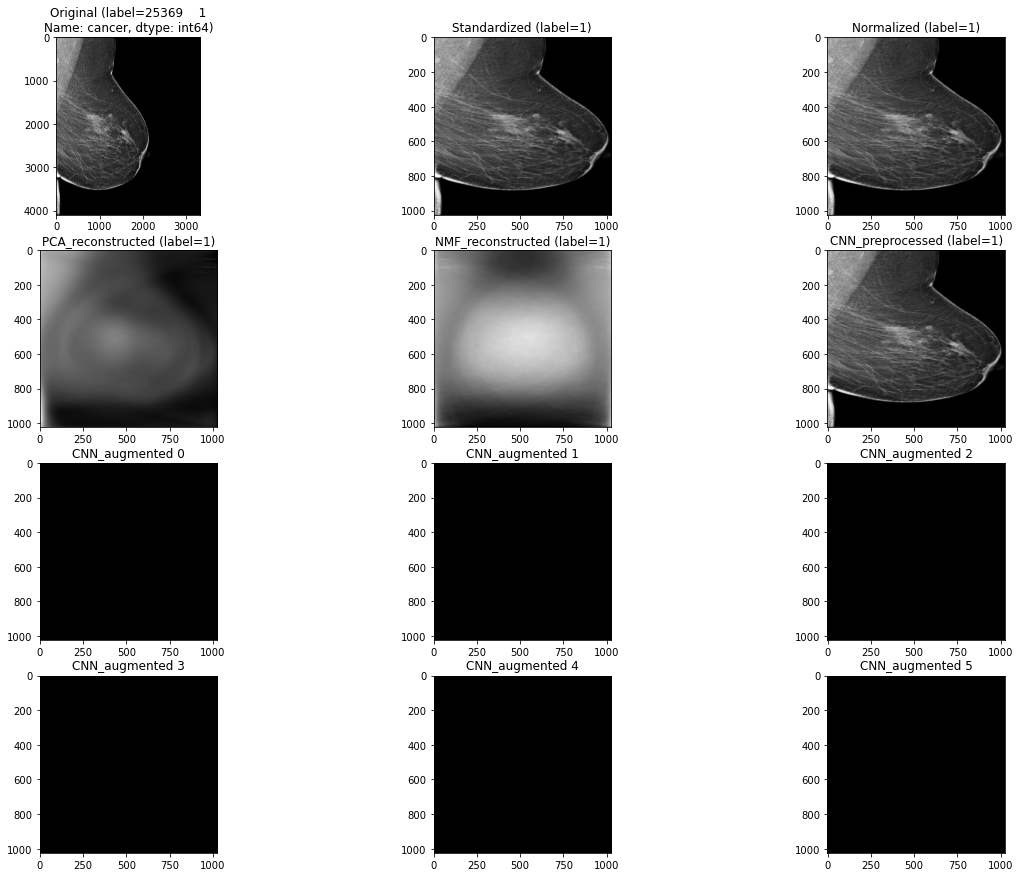

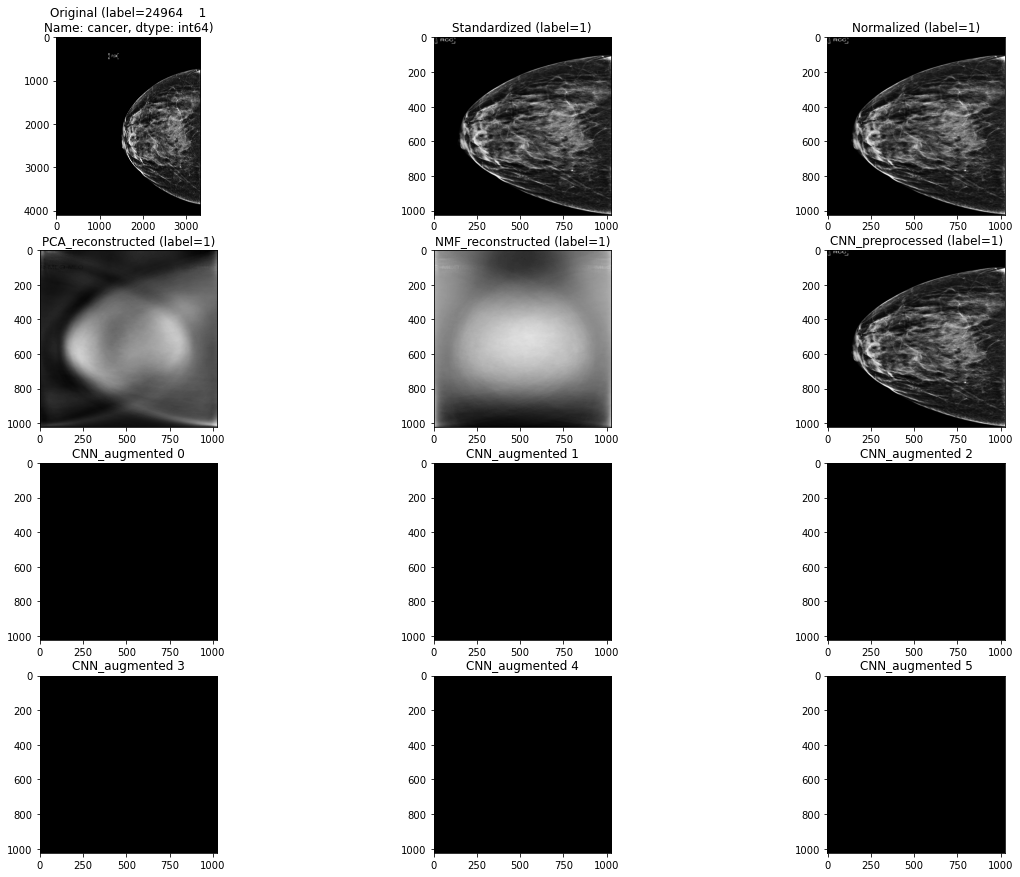

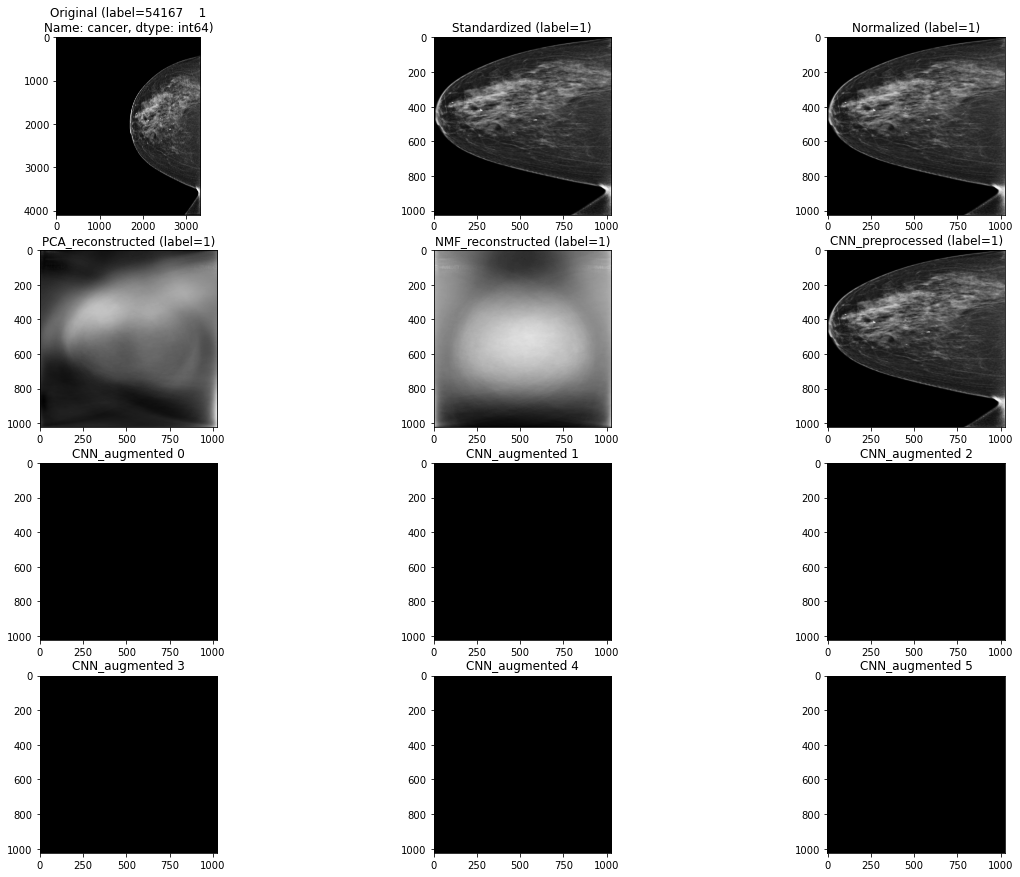

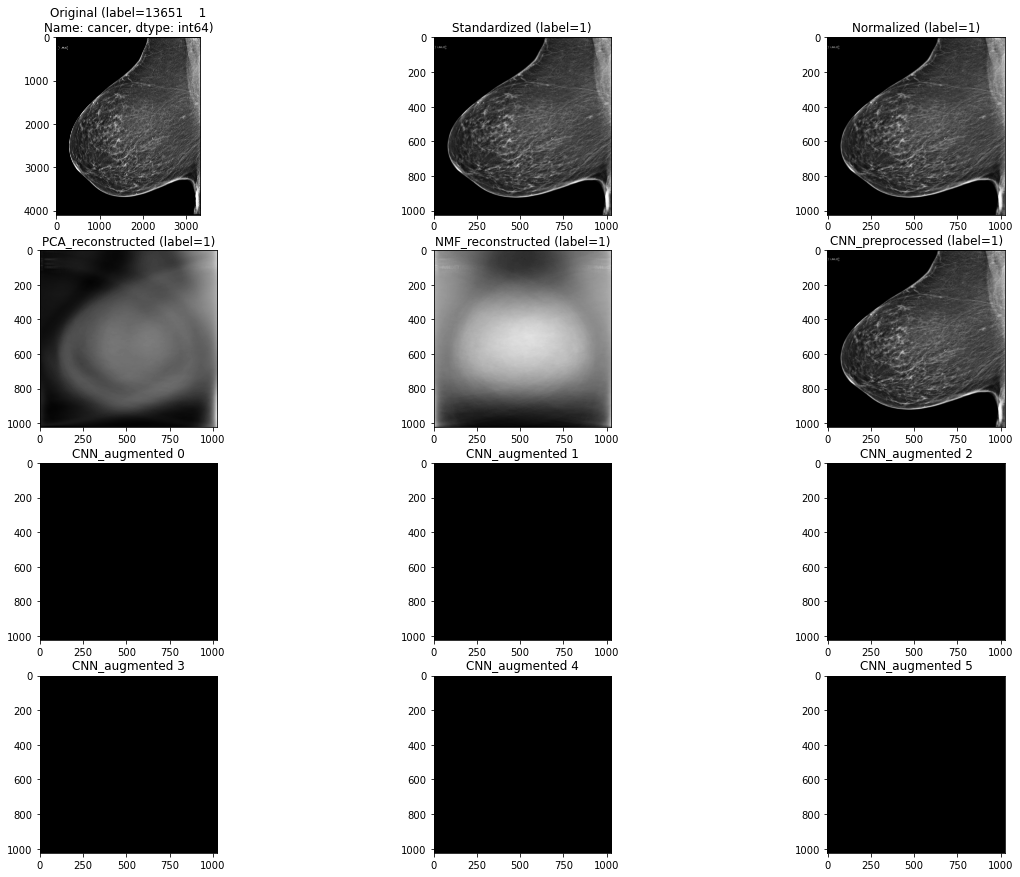

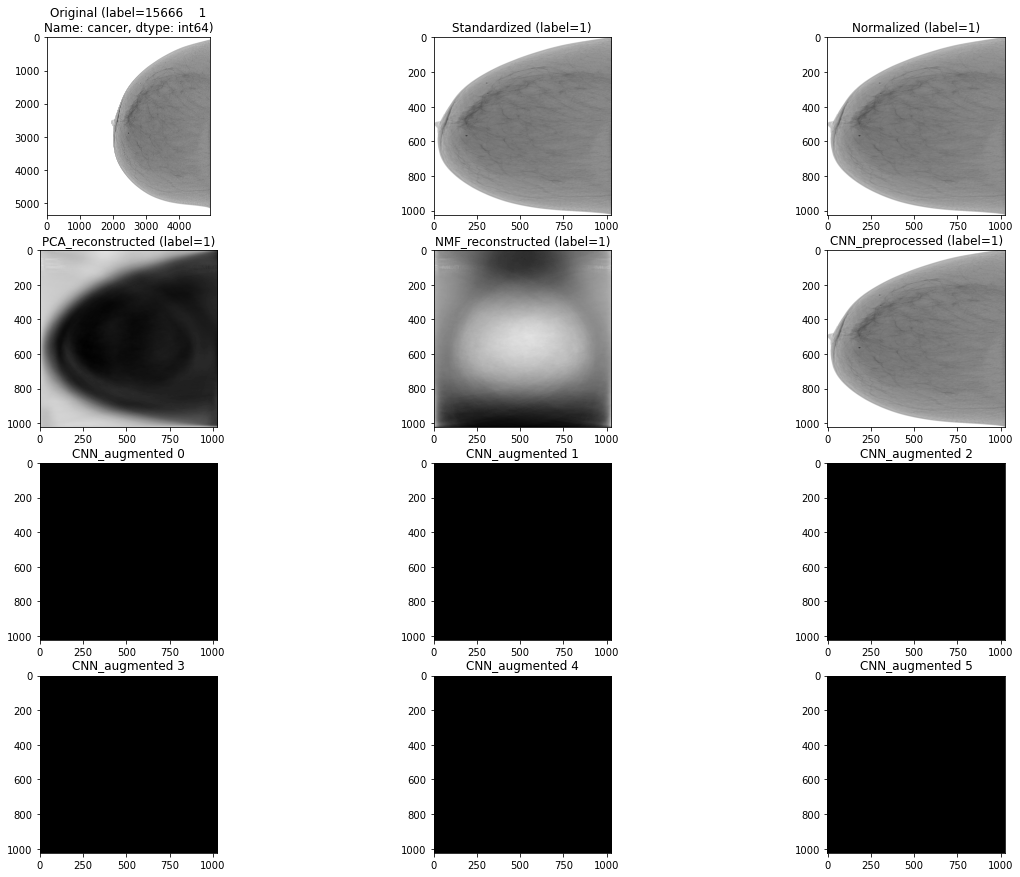

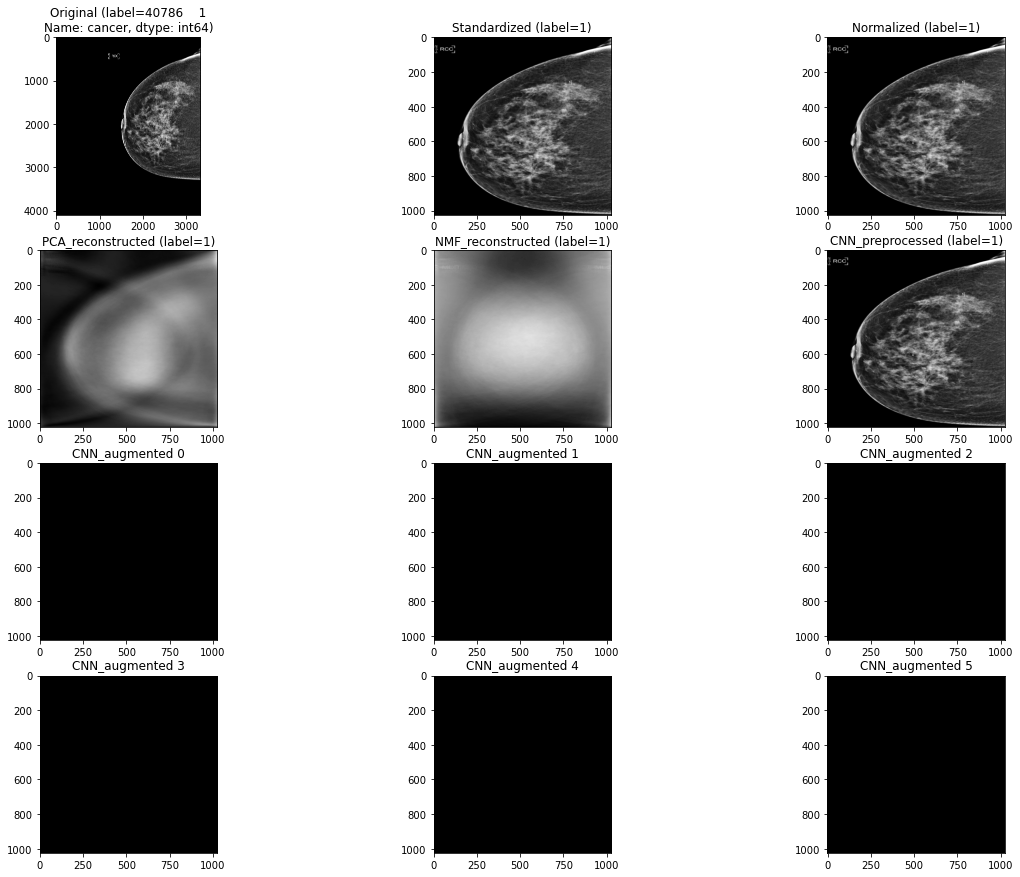

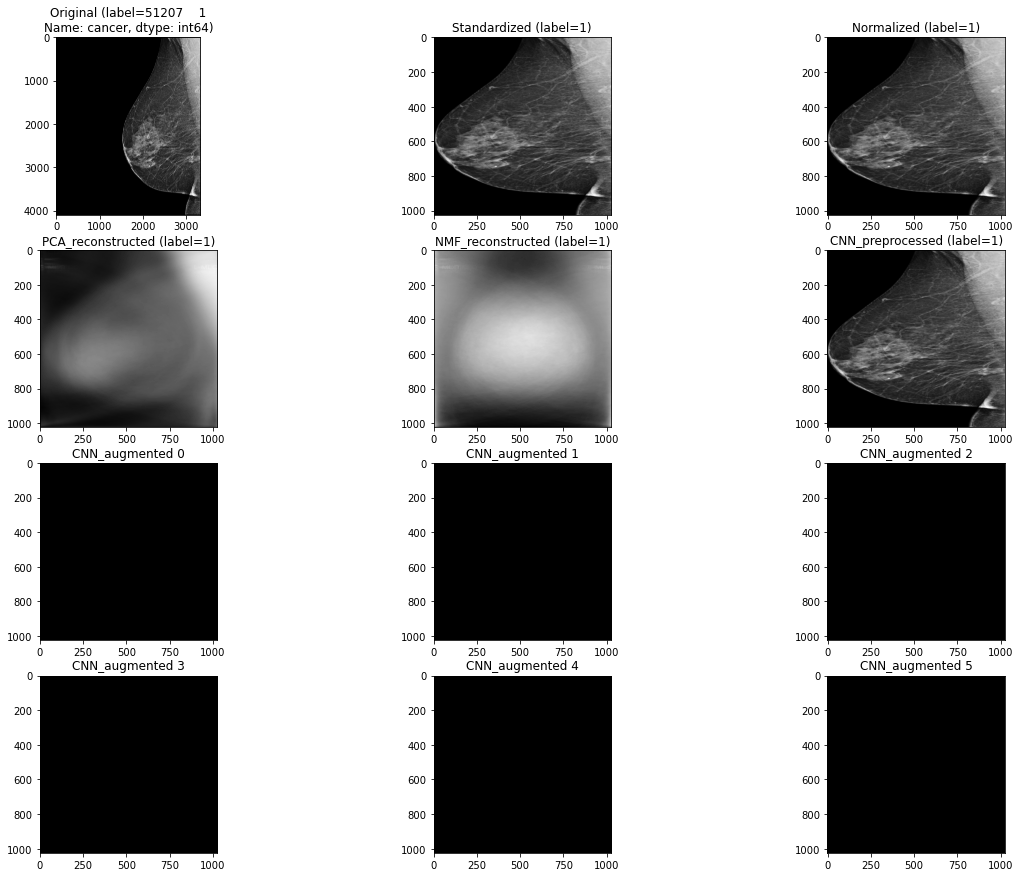

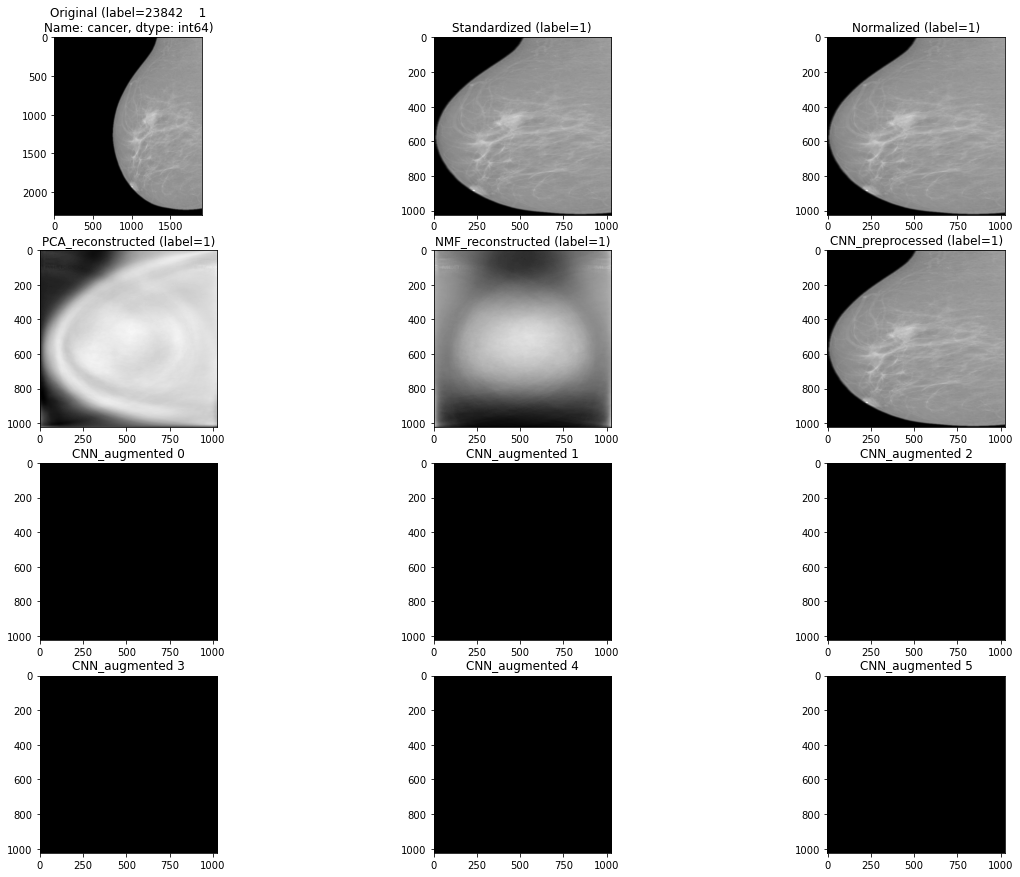

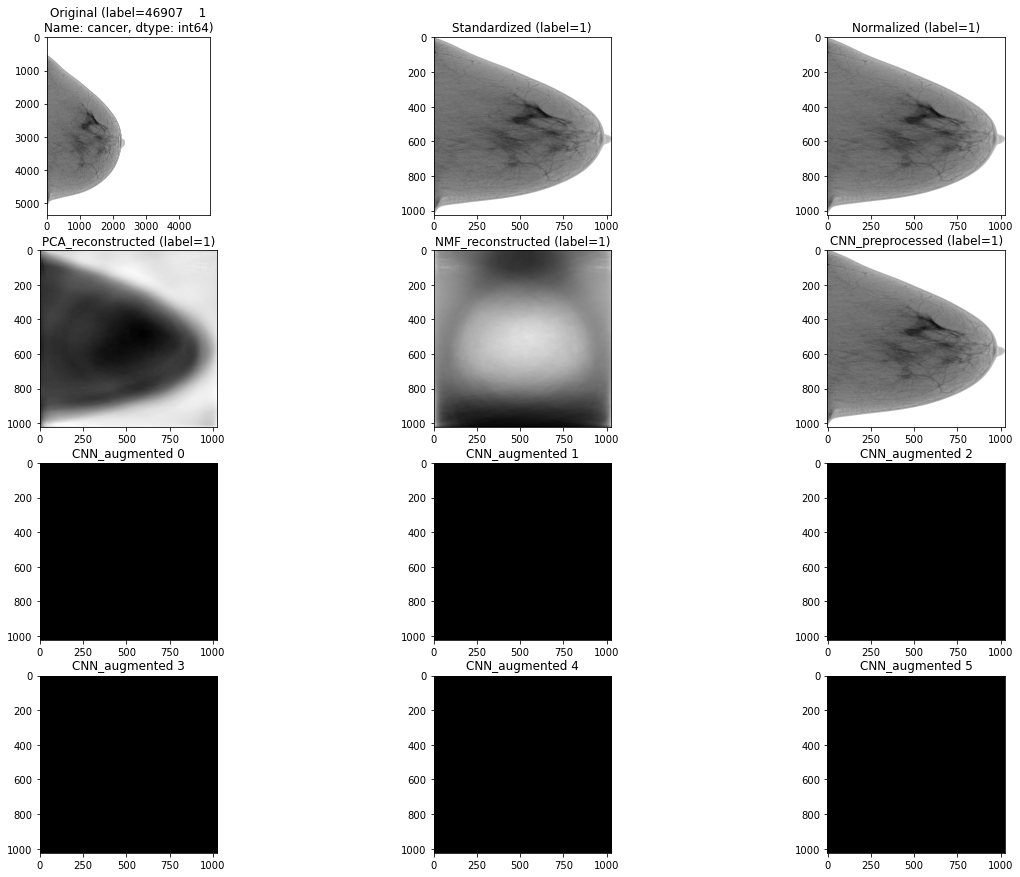

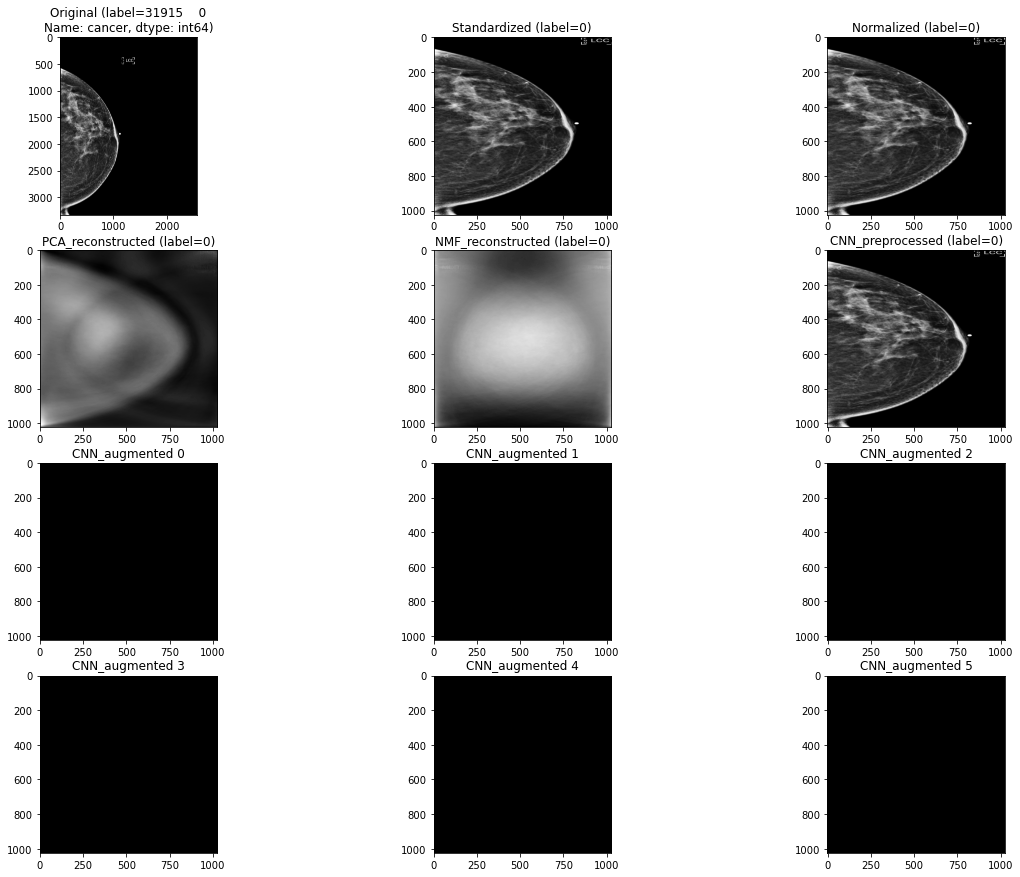

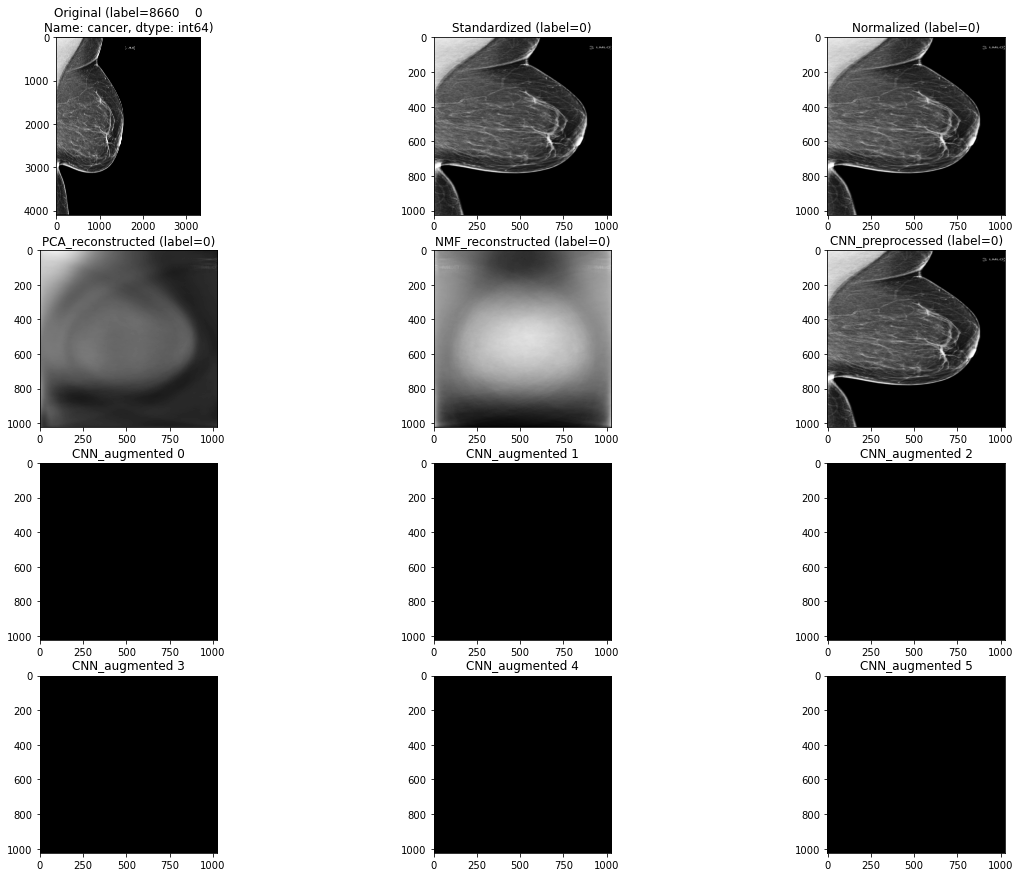

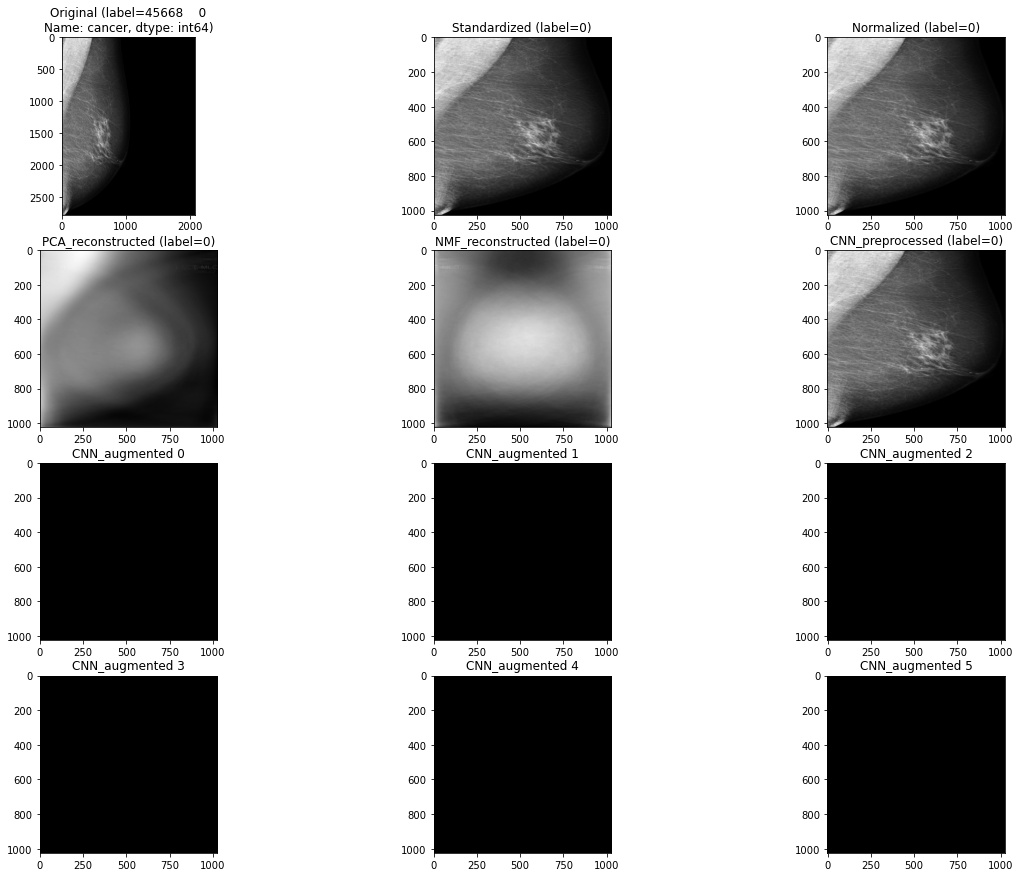

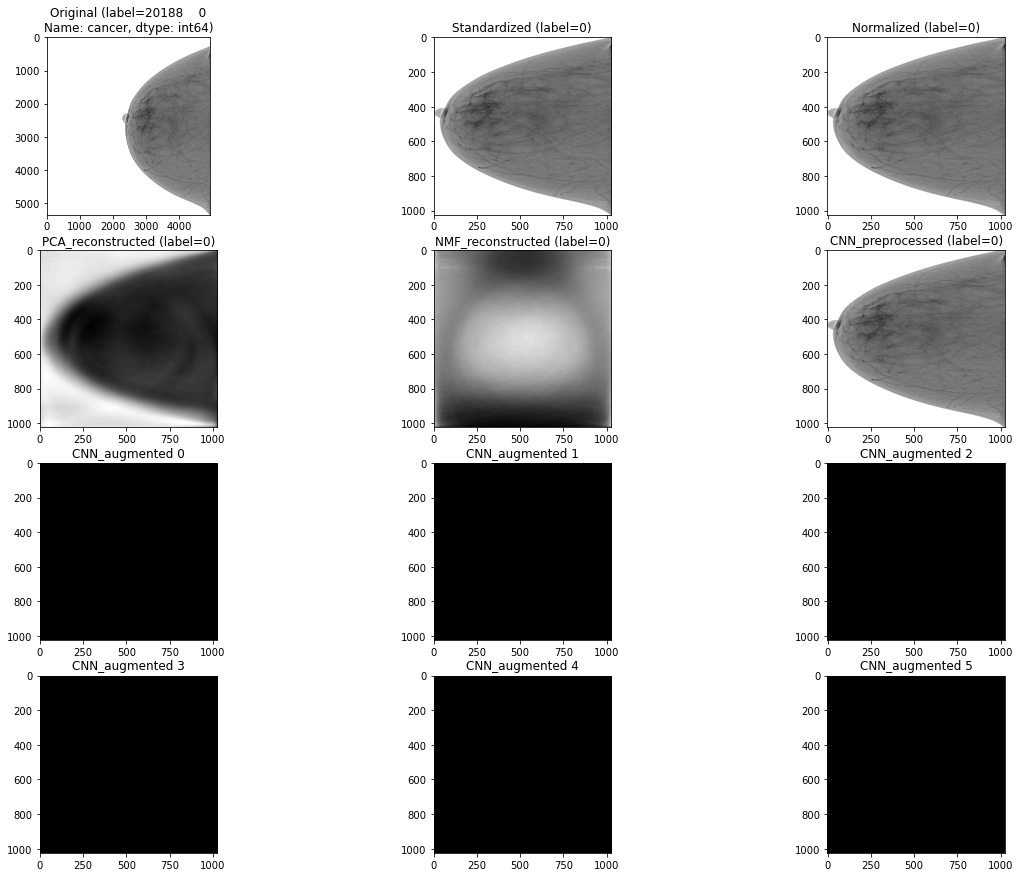

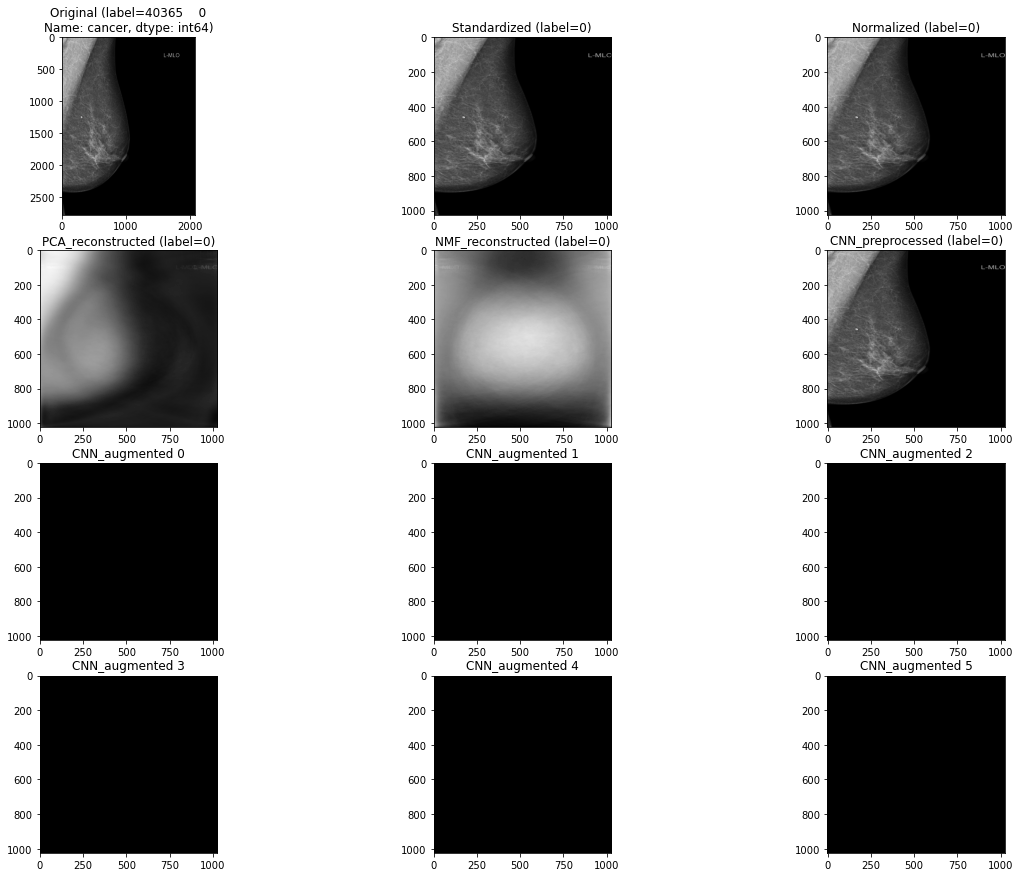

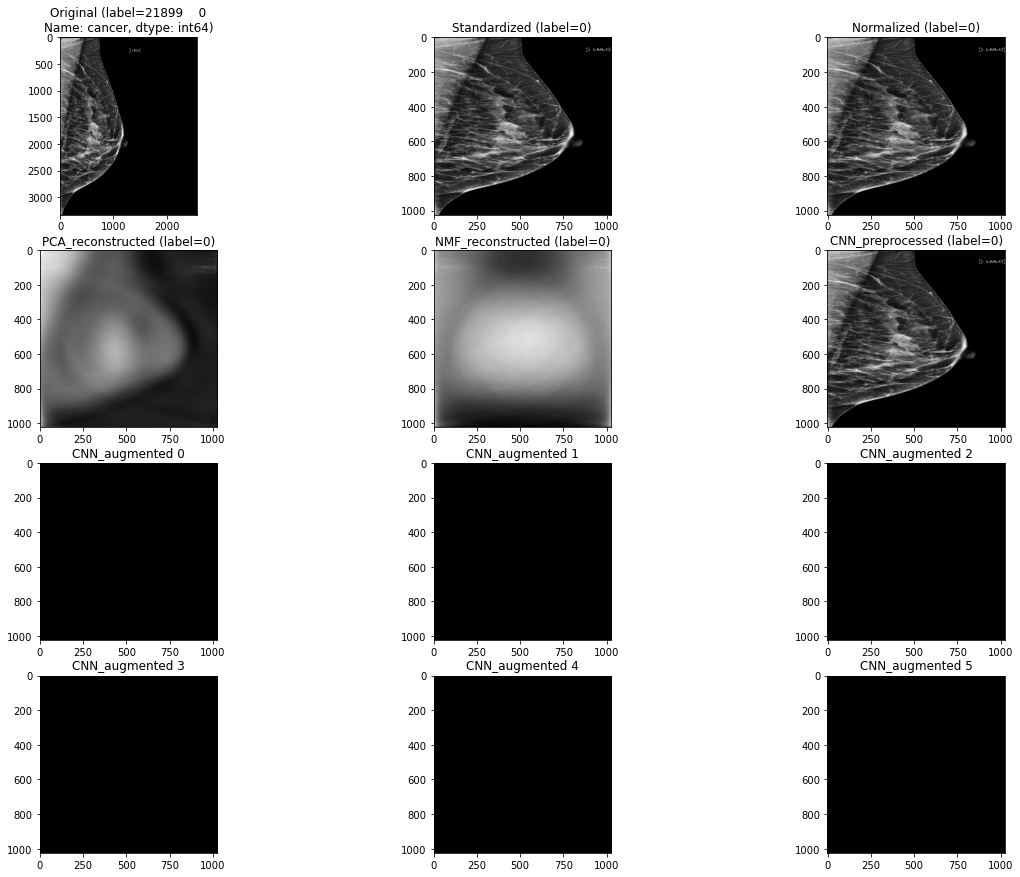

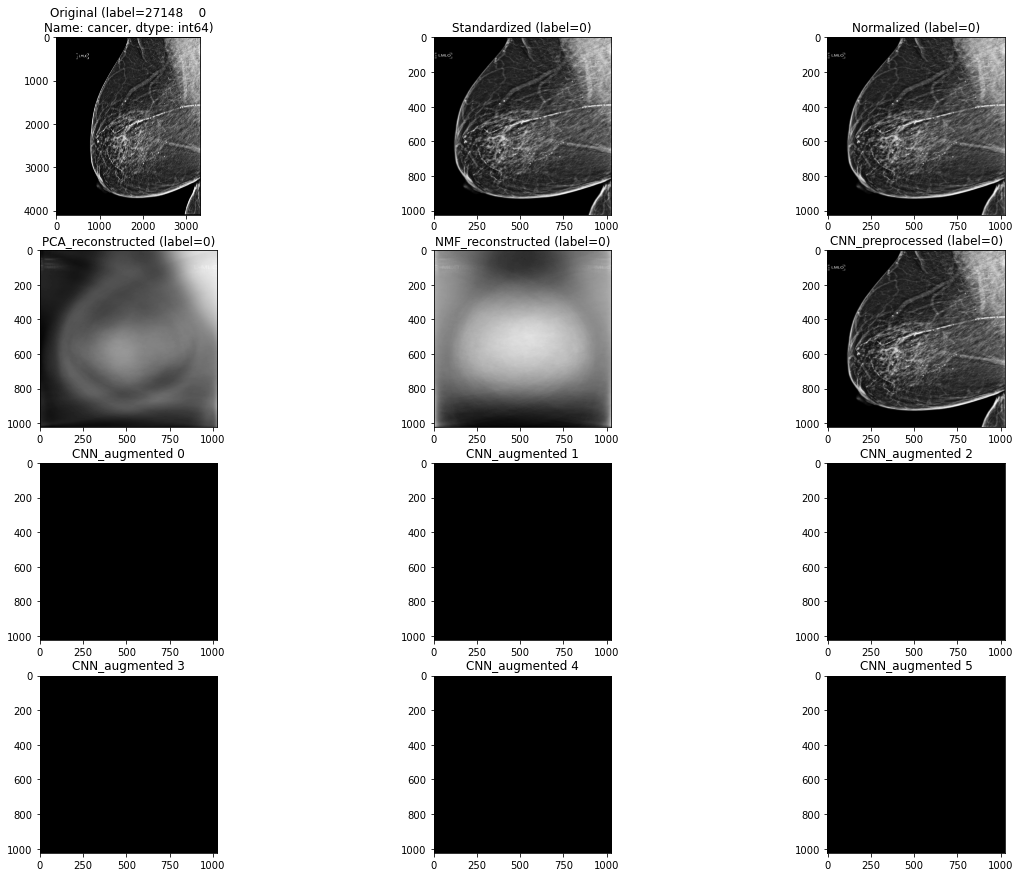

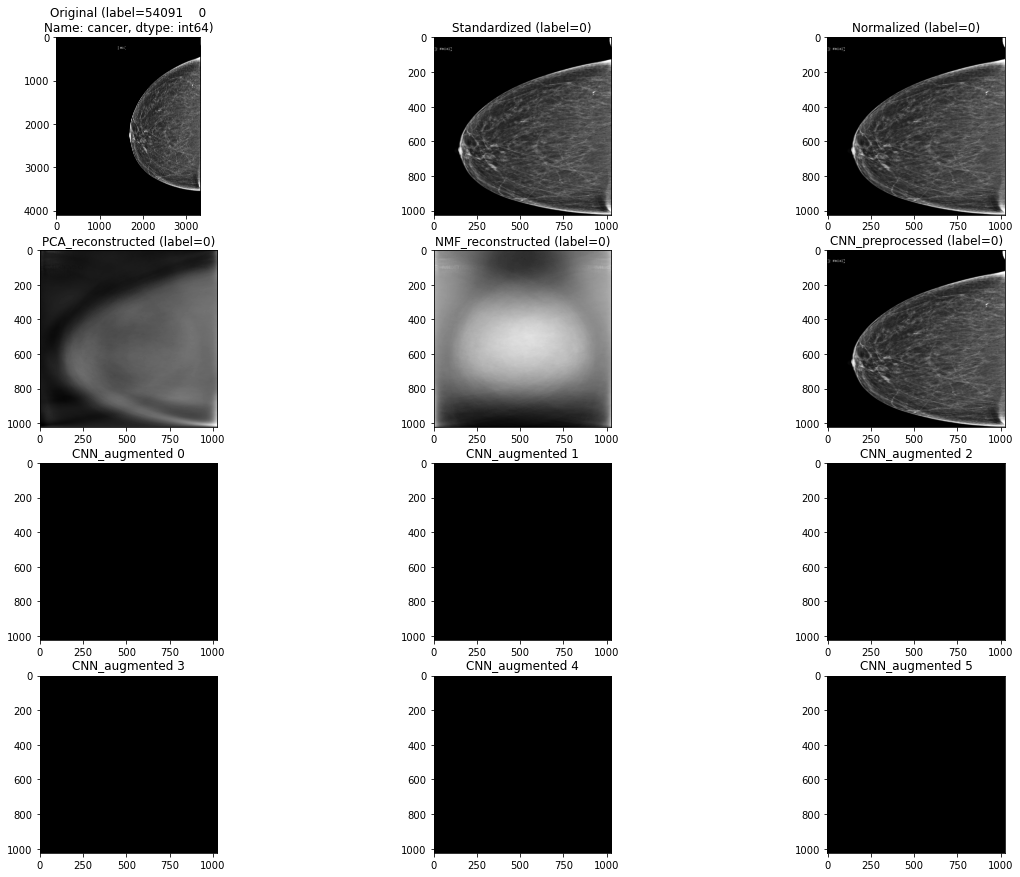

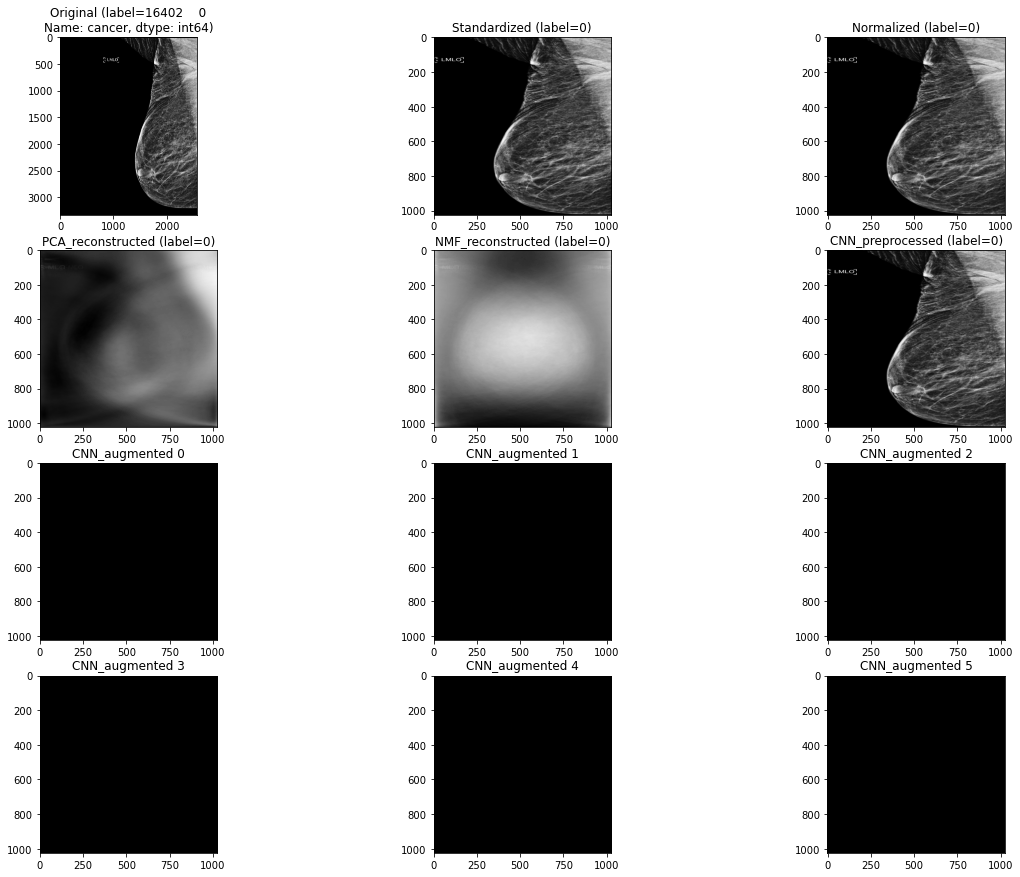

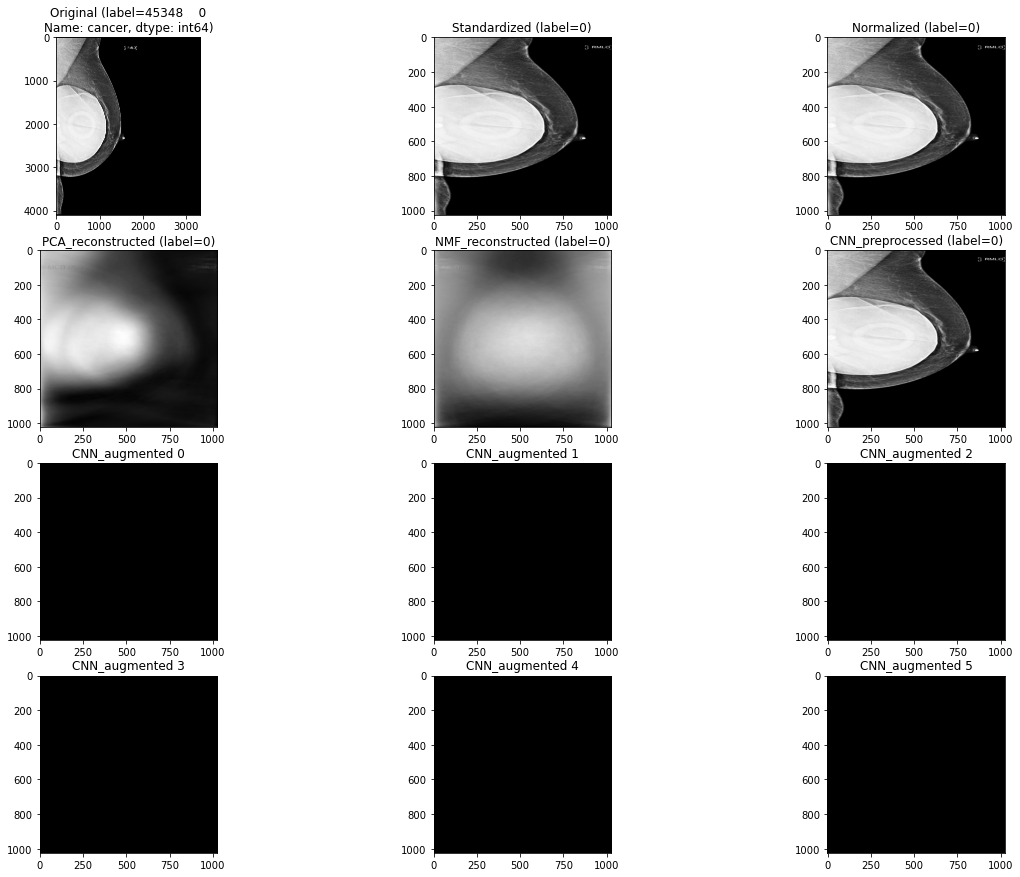

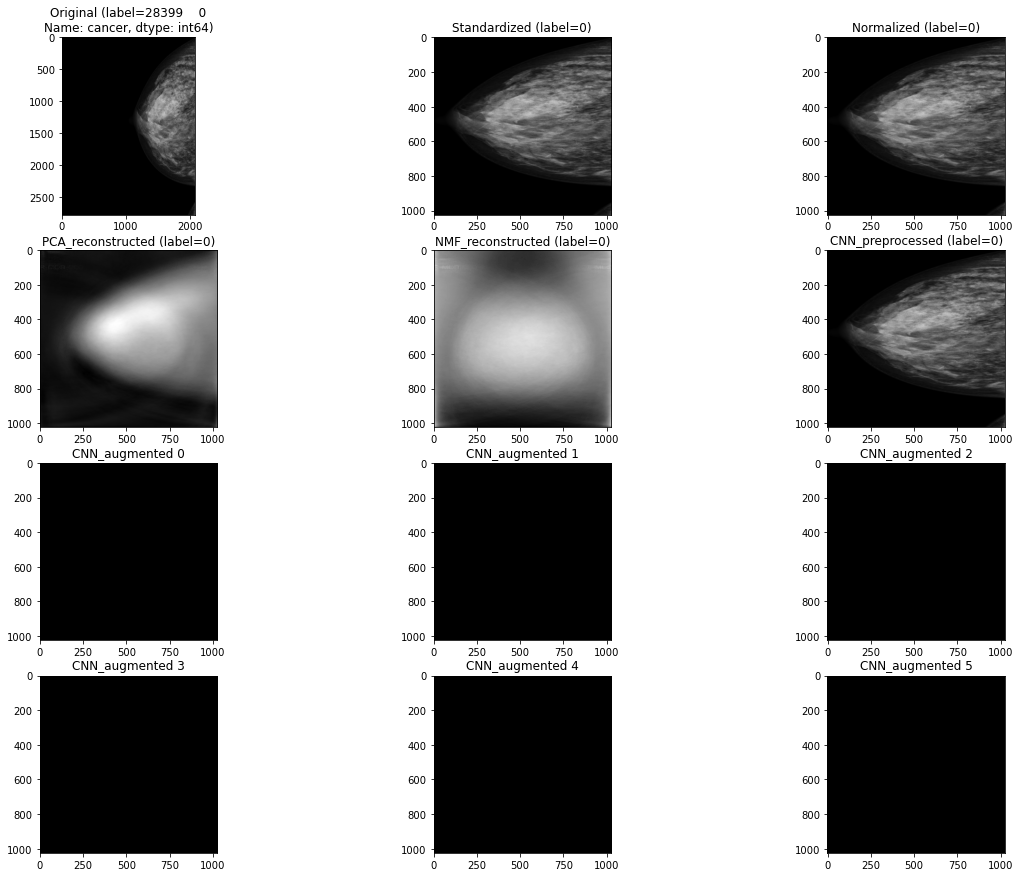

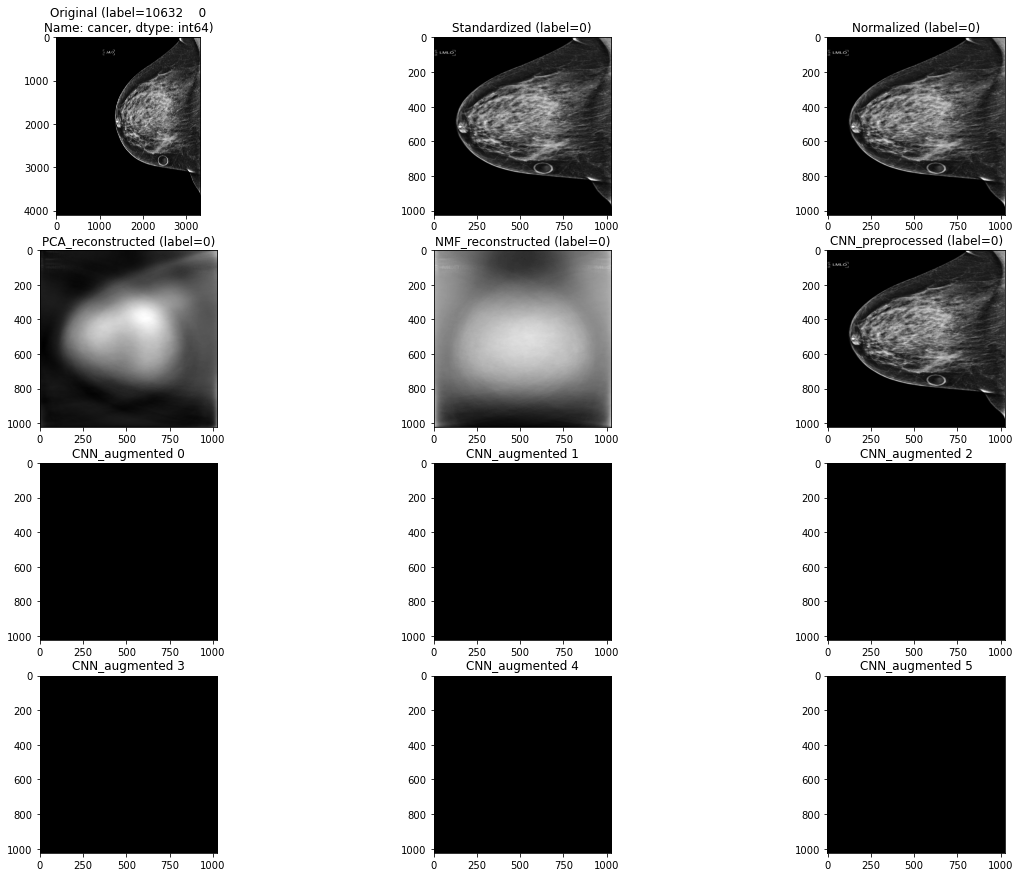

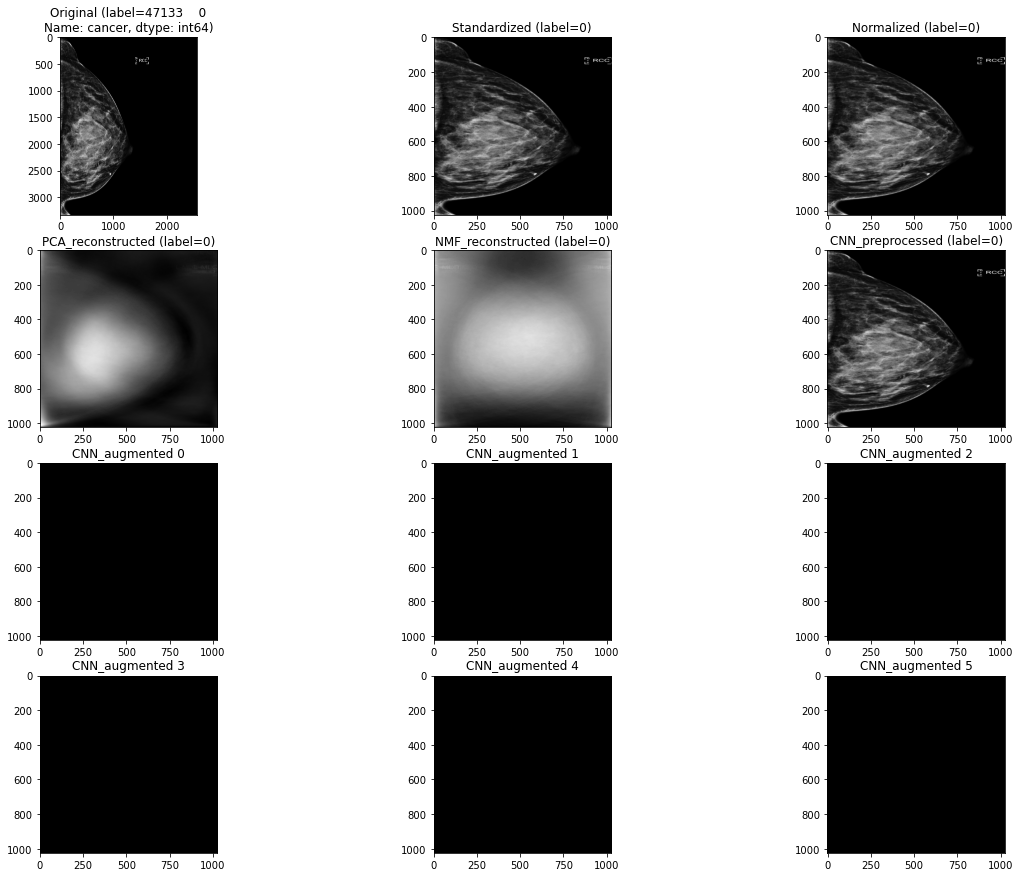

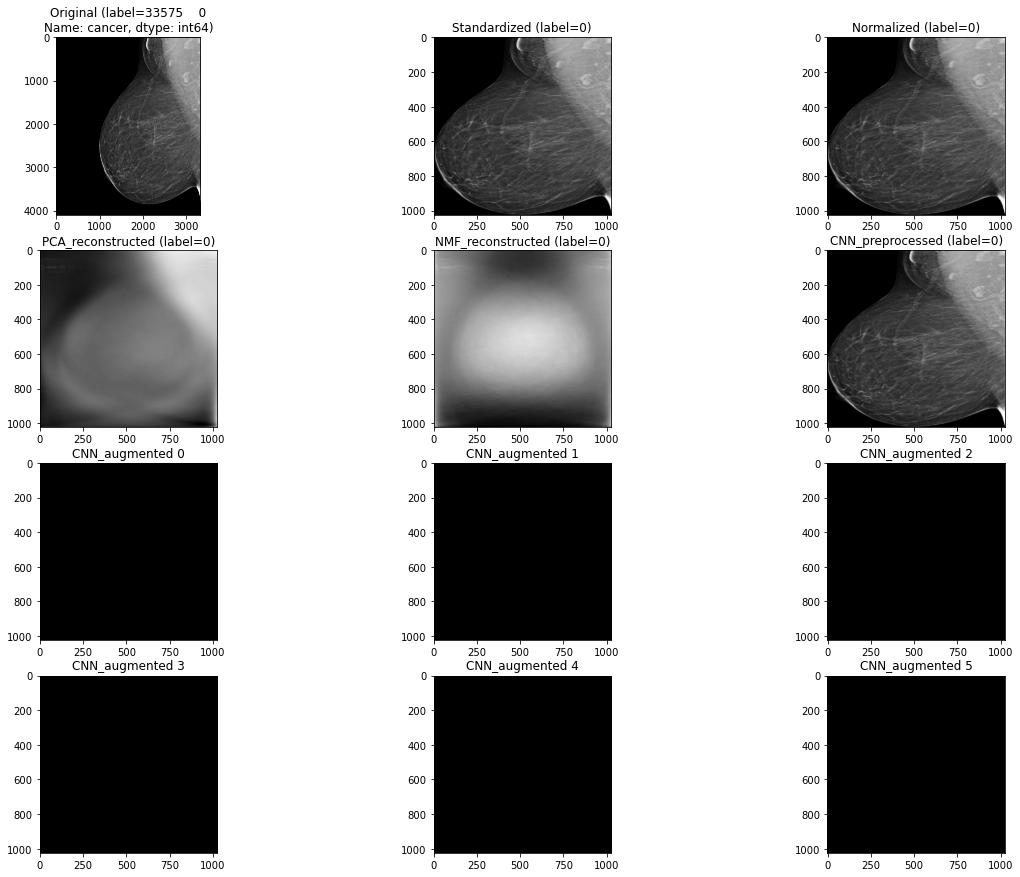

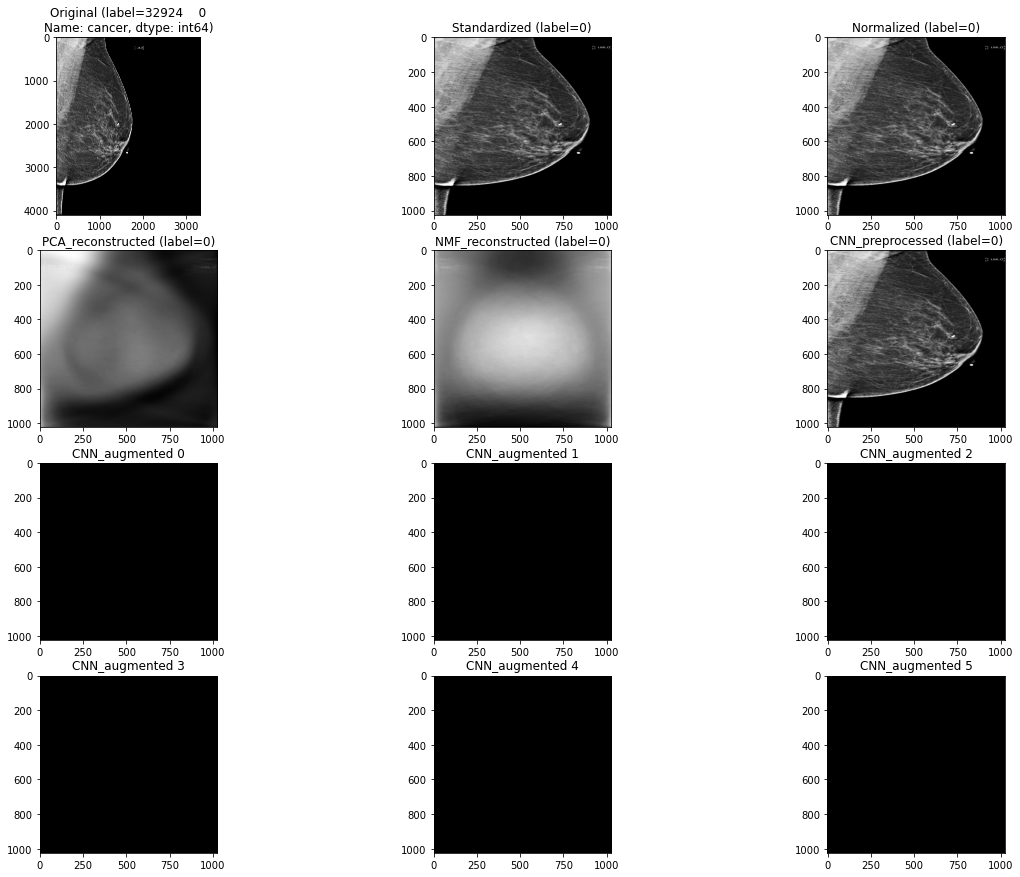

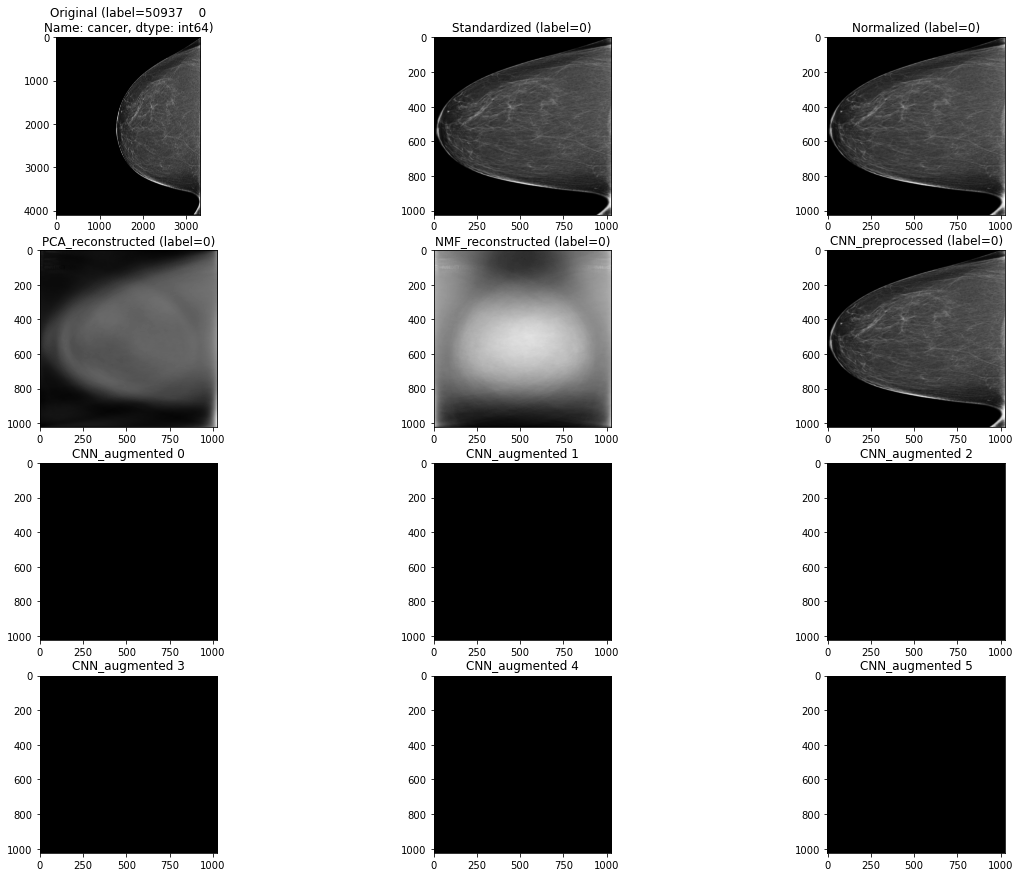

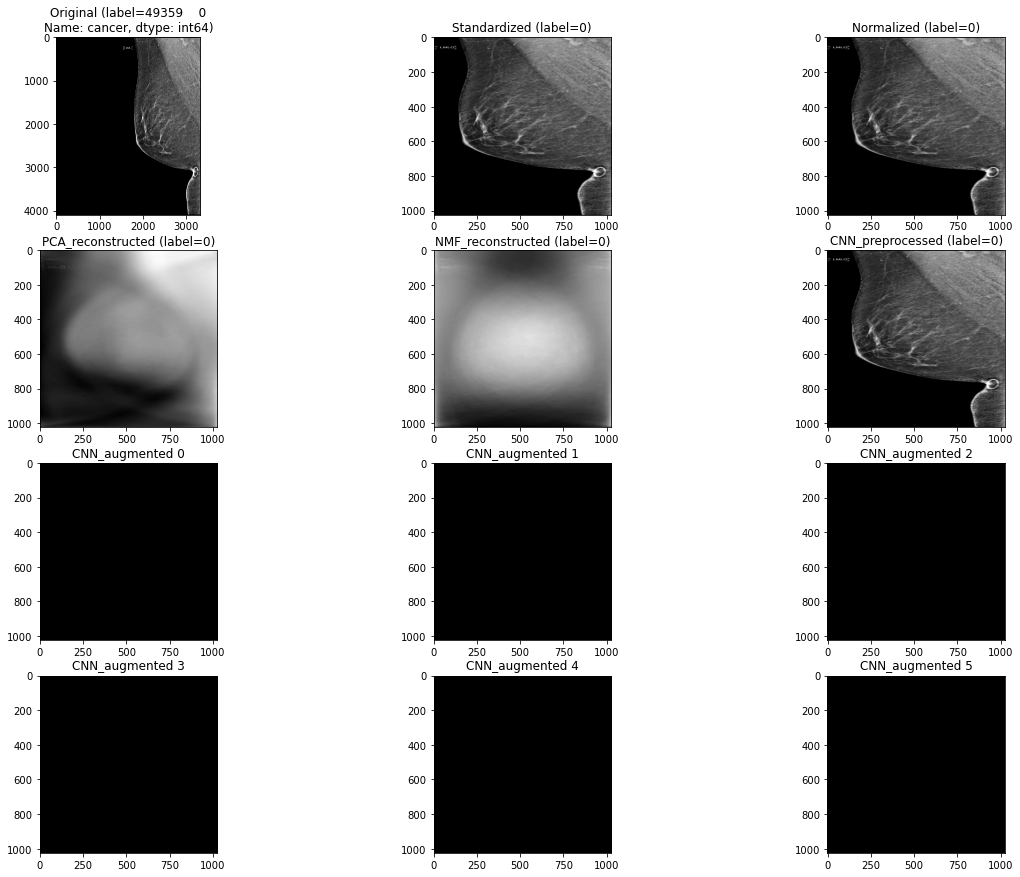

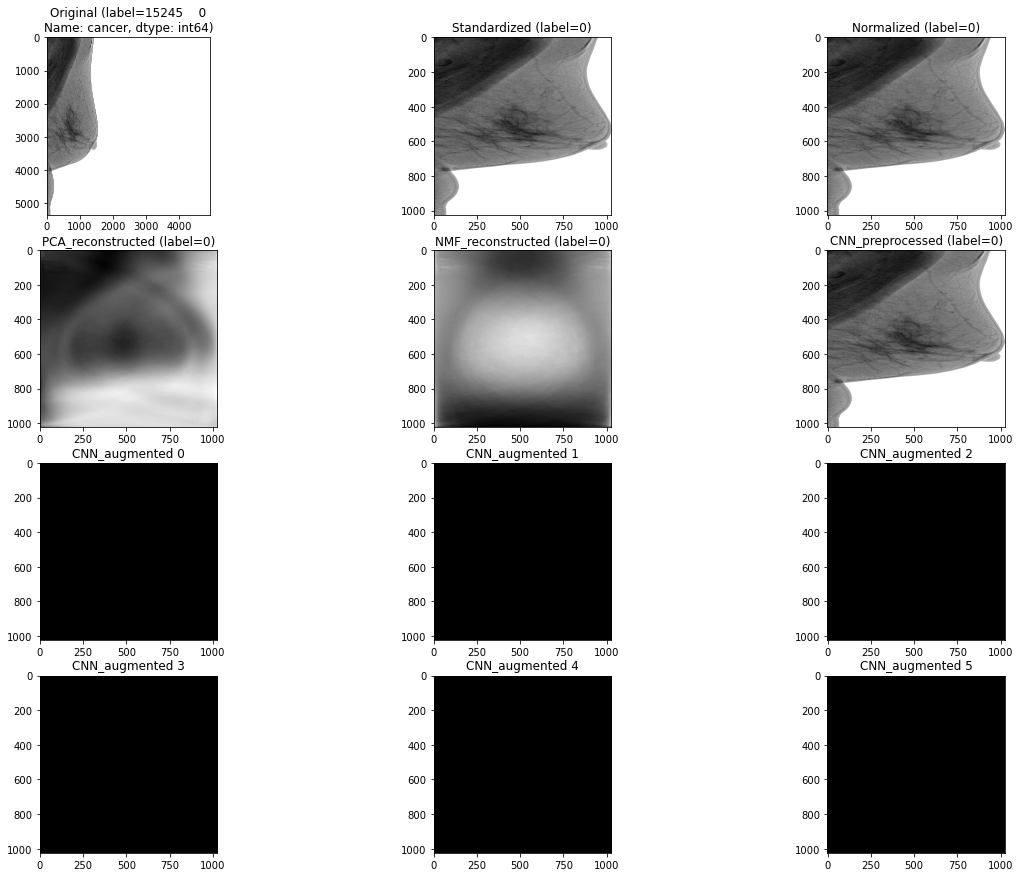

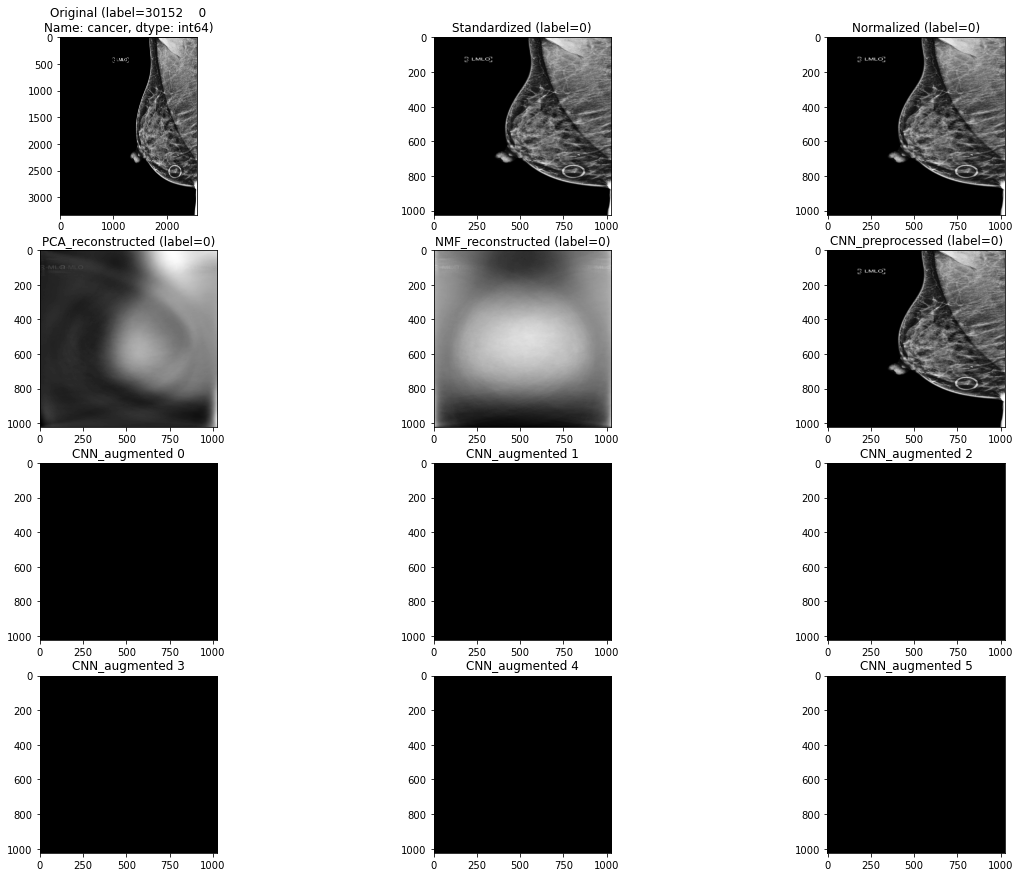

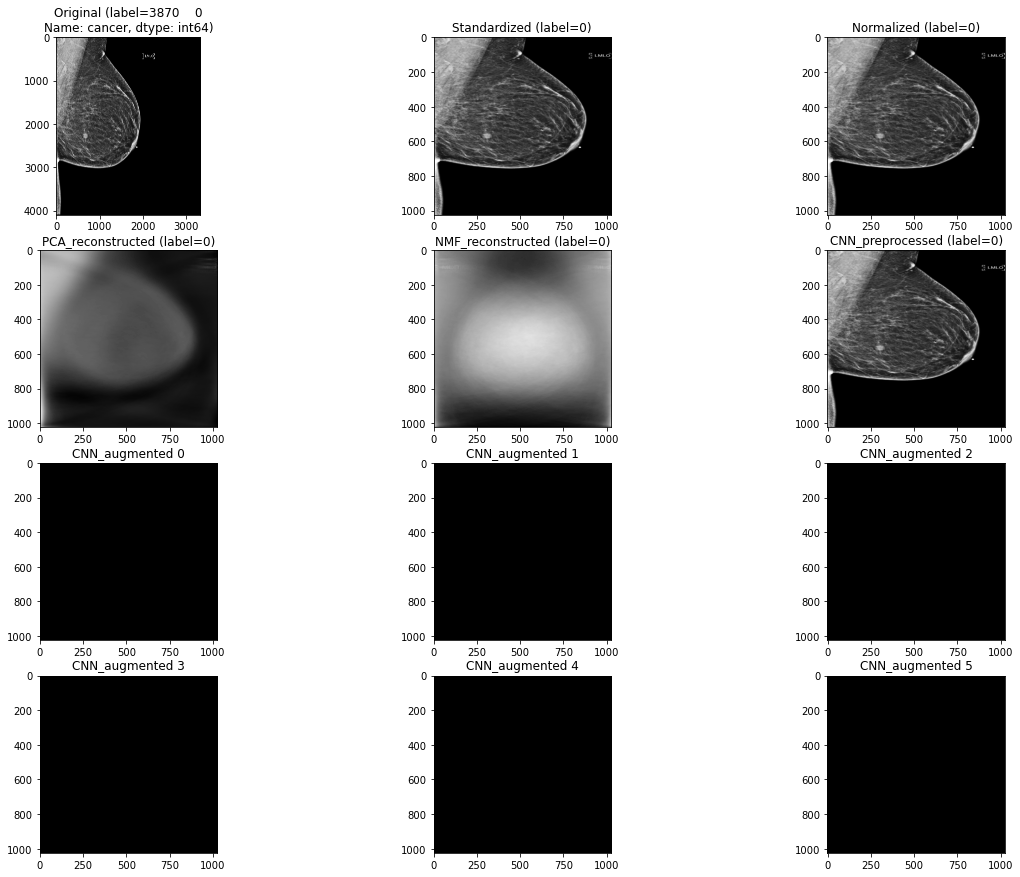

In [82]:
IMG_SIZE = (1024, 1024, 1)

for img_id in sample_img_ids:
    ev.vis_img_processing(
        dcm_path = '/scratch/siads699w23_class_root/siads699w23_class/shared_data/team_mammogram/train_images',
        numpy_path = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train',
        img_id = img_id,
        img_size = IMG_SIZE,
        labels = splitter.labels,
        patient_img_dict = splitter.trainset,
        extractor_path = 'models'
    )

# Determining the optimal no. of components

In [72]:
# image id of all sample training set
train_img_ids = [id for k, v in sample_splitter.train.items() for id in v]
print(len(train_img_ids))

32


## Principal component analysis

In [79]:
BATCH_SIZE = 32 # limitation: n_components must be less or equal to the batch number of samples
IMG_SIZE = (256, 256, 1)
BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train'

img_gen = dl.ImgGenerator(
    list_IDs = train_img_ids,
    patient_img_dict = sample_splitter.train,
    batch_size = BATCH_SIZE,
    basepath = BASEPATH,
    img_size = IMG_SIZE,
    normalize = (0, 1),
    from_numpy = True
)

ipca = fex.train_feature_extractor(
    img_gen = img_gen,
    model_name = 'PCA',
    n_components=None,
    save_path=None,
    verbose=True
)

Initialized PCA with n_components = None
--Training batch  1


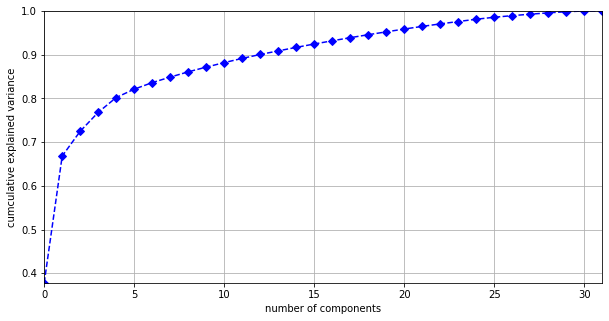

In [83]:
fig, axs = plt.subplots(figsize=(10, 5))

axs.plot(ipca.explained_variance_ratio_.cumsum(), marker='D', linestyle="--", color='blue')
axs.set_xlabel('number of components')
axs.set_ylabel('cumculative explained variance')
axs.margins(x=0,y=0)
plt.grid(axis='both')
plt.show()
# 8 components

### Train PCA on each fold's training split

In [93]:
N_COMPONENTS = 10

BATCH_SIZE = 10 # limitation: batch size must be at least equal or larger than n_components
IMG_SIZE = (256, 256, 1)
 
BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays
EXTRACTOR_PATH = '/home/irinb/models/demo' # directory to save trained models
RANDOM_STATE = 42

ipca_models, train_time = fex.cv_train_feature_extractor(
    cv_img = sample_cv_img,
    patient_img_dict = sample_splitter.trainset,
    batch_size = BATCH_SIZE,
    basepath = BASEPATH,
    img_size = IMG_SIZE,
    normalize = (0, 1),
    
    from_numpy = True,
    random_state = RANDOM_STATE,
    
    model_name = 'PCA',
    n_components = N_COMPONENTS, 
    extractor_path = EXTRACTOR_PATH,
    verbose = True,
    evaluate = False,
    return_none = False  
)

Fold:  0
Initialized PCA with n_components = 10
--Training batch  1
--Training batch  2
-->> Training time:  -0.17352867126464844
Fold:  1
Initialized PCA with n_components = 10
--Training batch  1
--Training batch  2
-->> Training time:  -0.18285346031188965
Fold:  2
Initialized PCA with n_components = 10
--Training batch  1
--Training batch  2
-->> Training time:  -0.1793053150177002
Fold:  3
Initialized PCA with n_components = 10
--Training batch  1
--Training batch  2
-->> Training time:  -0.18404412269592285
Fold:  4
Initialized PCA with n_components = 10
--Training batch  1
--Training batch  2
-->> Training time:  -0.18517684936523438


In [114]:
IMG_SIZE = (256, 256, 1)
BATCH_SIZE = 2

explained_var = {}
reconstruction_err = {}
for fold in range(5):
    
    ipca = ipca_models[fold]
    
    img_gen = dl.ImgGenerator(
        list_IDs = sample_cv_img[fold]['validate'],
        patient_img_dict = sample_splitter.trainset,
        batch_size = BATCH_SIZE,
        basepath = BASEPATH,
        img_size = IMG_SIZE,
        normalize = (0, 1),
        from_numpy = True
    )
    
    ex_var, rec_err = fex.evaluate_feature_extractor(img_gen, ipca, verbose=True)
    explained_var[fold] = ex_var
    reconstruction_err[fold] = rec_err

Start evaluation...
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
>> Calculating explained variance...
-->  -inf
>> Calculating reconstruction error...
-->  0.2520857433361527
Start evaluation...
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
>> Calculating explained variance...
-->  -inf
>> Calculating reconstruction error...
-->  0.13286598588386545
Start evaluation...
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
>> Calculating explained variance...
-->  0.7313394848779985
>> Calculating reconstruction error...
-->  0.08356284867912607
Start evaluation...
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
>> Calculating explained variance...
-->  -1.84000031966161
>> Calculating reconstruction error...
-->  0.2027663733925657
Start evaluation...
--Transforming batch  1
---Reconstructing batch

/home/irinb/feature_extraction.py:118: RuntimeWarning: divide by zero encountered in true_divide
  explained_var = np.mean(1 - (diff_stats.var/batch_stats.var))
/home/irinb/feature_extraction.py:118: RuntimeWarning: divide by zero encountered in true_divide
  explained_var = np.mean(1 - (diff_stats.var/batch_stats.var))


In [117]:
explained_var

{0: -inf,
 1: -inf,
 2: 0.7313394848779985,
 3: -1.84000031966161,
 4: 0.7244616722710177}

In [118]:
reconstruction_err

{0: 0.2520857433361527,
 1: 0.13286598588386545,
 2: 0.08356284867912607,
 3: 0.2027663733925657,
 4: 0.10007701284051947}

## Non-negative matrix factorization

In [133]:
BATCH_SIZE = 8
IMG_SIZE = (256, 256, 1)
BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train'

img_gen = dl.ImgGenerator(
    list_IDs = train_img_ids,
    patient_img_dict = sample_splitter.train,
    batch_size = BATCH_SIZE,
    basepath = BASEPATH,
    img_size = IMG_SIZE,
    normalize = (0, 1), # nmf input must be non-negative
    from_numpy = True
)

n_components_range = [2, 3, 5, 8, 10, 15, 20, 50, 100, 200, 500]
reconstruction_errs = {}
explained_vars = {}

for n_components in n_components_range:
    nmf = fex.train_feature_extractor(
        img_gen = img_gen,
        model_name = 'NMF',
        
        n_components=n_components,
        init = 'random',
        beta_loss= 'kullback-leibler',
        alpha_W = 0,
        l1_ratio = 1,
        
        save_path=None,
        verbose=True
    )
  
    ex_var, rec_err = fex.evaluate_feature_extractor(img_gen, nmf, verbose=True)
    explained_vars[n_components] = ex_var
    reconstruction_errs[n_components] = rec_err

Initialized NMF with n_components = 2
--Training batch  1
--Training batch  2
--Training batch  3
--Training batch  4
Start evaluation...
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
--Transforming batch  3
---Reconstructing batch
--Transforming batch  4
---Reconstructing batch
>> Calculating explained variance...
-->  0.17775886234805321
>> Calculating reconstruction error...
-->  0.3618064142712601
Initialized NMF with n_components = 3
--Training batch  1
--Training batch  2
--Training batch  3
--Training batch  4
Start evaluation...
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
--Transforming batch  3
---Reconstructing batch
--Transforming batch  4
---Reconstructing batch
>> Calculating explained variance...
-->  0.17819938719283052
>> Calculating reconstruction error...
-->  0.3615803276036153
Initialized NMF with n_components = 5
--Training batch  1
--Training batch  2
--Training b

{2: 0.17775886234805321, 3: 0.17819938719283052, 5: 0.1807969926339486, 8: 0.2565698220996308, 10: 0.3090211699582233, 15: 0.37576723850391436, 20: 0.4109005356051723, 50: 0.45765090091222593, 100: 0.5195627734677382, 200: 0.5303922726143386, 500: 0.5511215358279464}


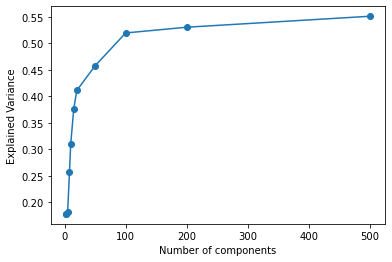

In [134]:
print(explained_vars)

plt.plot(n_components_range, explained_vars.values(), 'o-')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance')
plt.show()
# 100 components

{2: 0.3618064142712601, 3: 0.3615803276036153, 5: 0.3586481222874809, 8: 0.3128874977227954, 10: 0.28879827487435755, 15: 0.25831503238307857, 20: 0.2416827017925011, 50: 0.22249704708830417, 100: 0.19787614129811476, 200: 0.19408312608268039, 500: 0.18594965704879793}


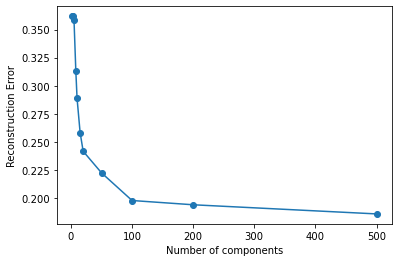

In [135]:
print(reconstruction_errs)

plt.plot(n_components_range, reconstruction_errs.values(), 'o-')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.show()
# 100 components

In [136]:
EXTRACTOR_PATH = 'models/demo'
BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train'

N_COMPONENTS = 100
BATCH_SIZE = 4 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

nmf_models, train_time, explained_var, reconstruction_err = fex.cv_train_feature_extractor(
        cv_img = sample_cv_img,
        patient_img_dict = sample_splitter.train,
    
        batch_size = BATCH_SIZE,
        basepath = BASEPATH,
        img_size = IMG_SIZE,
        normalize = (0, 1),
        random_state = RANDOM_STATE,
    
        model_name = 'NMF',
        n_components = N_COMPONENTS,
        init = 'random',
        beta_loss= 'kullback-leibler',
        alpha_W = 0,
        l1_ratio = 1,
        
        extractor_path = EXTRACTOR_PATH,
    
        verbose = True,
        evaluate = True,
        return_none = False    
        )

Fold:  0
Initialized NMF with n_components = 100
--Training batch  1
--Training batch  2
--Training batch  3
--Training batch  4
--Training batch  5
-->> Training time:  -3.0254390239715576
Start evaluation...
--Transforming batch  1
---Reconstructing batch
>> Calculating explained variance...
-->  -inf
>> Calculating reconstruction error...
-->  0.32377766706608463
Fold:  1
Initialized NMF with n_components = 100
--Training batch  1


/home/irinb/feature_extraction.py:118: RuntimeWarning: divide by zero encountered in true_divide
  explained_var = np.mean(1 - (diff_stats.var/batch_stats.var))


--Training batch  2
--Training batch  3
--Training batch  4
--Training batch  5
-->> Training time:  -2.8714656829833984
Start evaluation...
--Transforming batch  1
---Reconstructing batch
>> Calculating explained variance...
-->  -inf
>> Calculating reconstruction error...
-->  0.21768856885449459
Fold:  2
Initialized NMF with n_components = 100
--Training batch  1


/home/irinb/feature_extraction.py:118: RuntimeWarning: divide by zero encountered in true_divide
  explained_var = np.mean(1 - (diff_stats.var/batch_stats.var))


--Training batch  2
--Training batch  3
--Training batch  4
--Training batch  5
-->> Training time:  -2.938096284866333
Start evaluation...
--Transforming batch  1
---Reconstructing batch
>> Calculating explained variance...
-->  -0.3173801478762194
>> Calculating reconstruction error...
-->  0.23659022608840277
Fold:  3
Initialized NMF with n_components = 100
--Training batch  1
--Training batch  2
--Training batch  3
--Training batch  4
--Training batch  5
-->> Training time:  -3.3113021850585938
Start evaluation...
--Transforming batch  1
---Reconstructing batch
>> Calculating explained variance...
-->  -0.6555159750873545
>> Calculating reconstruction error...
-->  0.22218473037816378
Fold:  4
Initialized NMF with n_components = 100
--Training batch  1
--Training batch  2
--Training batch  3
--Training batch  4
--Training batch  5
-->> Training time:  -3.4365017414093018
Start evaluation...
--Transforming batch  1
---Reconstructing batch
>> Calculating explained variance...
-->  0.

In [137]:
explained_var

{0: -inf,
 1: -inf,
 2: -0.3173801478762194,
 3: -0.6555159750873545,
 4: 0.1948518613772349}

In [138]:
reconstruction_err

{0: 0.32377766706608463,
 1: 0.21768856885449459,
 2: 0.23659022608840277,
 3: 0.22218473037816378,
 4: 0.18521180979570634}

# Example training pipelines

Note: There is a bug in keras/tensorflow 2.9 and 2.10, which causes some preprocess layers to be extremly slow: https://github.com/tensorflow/tensorflow/issues/56242

For speed, try the model without the rescaling layer, or use Tensorflow version 2.8.3 or older.

## Augmentation + CNN

In [ ]:
IMG_SIZE = (32, 32, 1)

model_layers = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model_layers.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 8)                 86536     
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                      

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

EPOCH = 1 
BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits
LEARNING_RATE = 0.001
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone/Models/checkpoint_augment'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath = CHECKPOINT_PATH,
     save_weights_only = False,
     monitor = 'val_auc',
     mode = 'max',
     save_best_only = True
     )


history = rm.run_cv_training(
    model_layers = model_layers,
    cv_img = sample_cv_img,

    augment_layers = True,
    base_model = None,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = METRICS,

    label_img_dict = sample_label_by_img,
    patient_img_dict = splitter.train,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE, 
    img_size = (IMG_SIZE[0], IMG_SIZE[1]),
    n_classes = 2,
    shuffle = True,
    normalize = (-1, 1), 

    feature_extractor_name = None,
    n_components = None,
    extractor_path = EXTRACTOR_PATH,
    random_state = RANDOM_STATE,

    checkpoint_path = CHECKPOINT_PATH,
    strategy = None,
    epoch = EPOCH,
    callbacks = None,
    use_multiprocessing = False,
    workers = 1,
    verbose = 1,

    return_none = False
    )

NameError: ignored

Using distribute strategy

In [ ]:
tf.test.gpu_device_name()

''

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 735684540493074682
 xla_global_id: -1]

In [ ]:
strategy = tf.distribute.MirroredStrategy(
    cross_device_ops=tf.distribute.ReductionToOneDevice()
    )

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


## PCA + NN

Train PCA or load pre-trained model with pre-determined no. of components on the training split of each cross-validation fold

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits

N_COMPONENTS = 4 # limitation: must be less than or equal to batch size

fex.cv_train_feature_extractor(
        cv_img = sample_cv_img,
        patient_img_dict = sample_splitter.train,
        batch_size = BATCH_SIZE,
        basepath = BASEPATH,
        img_size = IMG_SIZE,
        normalize = (-1, 1),
        random_state = RANDOM_STATE,
        model_name = 'PCA',
        n_components = N_COMPONENTS, 
        extractor_path = EXTRACTOR_PATH,
        verbose = True,
        evaluate = False,
        return_none = True    
        )

Fold:  0
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_0.pkl
Fold:  1
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_1.pkl
Fold:  2
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_2.pkl
Fold:  3
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_3.pkl
Fold:  4
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_4.pkl


Test running on 1 fold

In [ ]:
feat_ext = pickle.load(open('/content/drive/MyDrive/Capstone/Models/PCA_4_42_0.pkl', 'rb'))

In [ ]:
train_gen, val_gen = rm.get_train_val_generators(
        sample_cv_img[0]['train'],
        sample_cv_img[0]['validate'],
        label_img_dict = sample_label_by_img,
        patient_img_dict = splitter.train, 
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        n_classes=2,
        shuffle=True,
        normalize=(-1, 1),
        feature_extractor=feat_ext
        )

In [ ]:
model_layers = keras.Sequential([
    keras.layers.Input(shape=(N_COMPONENTS,)), 
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model_layers.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 12)                204       
                                                                 
 dense_4 (Dense)             (None, 2)                 26        
                                                                 
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape = (N_COMPONENTS,),
    augment_layers = False,
    base_model = None,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = keras.metrics.AUC()
    )
model.summary()

Checkpoint path:  /content/checkpoint
---Checkpoint folder created:  /content/checkpoint
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 12)                204       
                                                                 
 dense_4 (Dense)             (None, 2)                 26        
                                                                 
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
        train_gen,
        epochs=1,
        callbacks=None,
        validation_data=val_gen,
        use_multiprocessing = False,
        workers = 1,
        verbose = 1
    )

6/6 [==============================] - ETA: 0s - loss: 3.6382 - auc: 0.0104    

6/6 [==============================] - 47s 9s/step - loss: 3.6382 - auc: 0.0104 - val_loss: 2.6497 - val_auc: 0.0000e+00


Run the model on full cross-validation folds

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

EPOCH = 1 
BATCH_SIZE = 4
N_COMPONENTS = 4 # limitation: must be less than or equal to batch size
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits
LEARNING_RATE = 0.001
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone/Models/checkpoint_pca'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath = CHECKPOINT_PATH,
     save_weights_only = False,
     monitor = 'val_auc',
     mode = 'max',
     save_best_only = True
     )


history = rm.run_cv_training(
    model_layers = model_layers,
    cv_img = sample_cv_img,

    augment_layers = False,
    base_model = None,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = METRICS,

    label_img_dict = sample_label_by_img,
    patient_img_dict = splitter.train,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE, 
    img_size = IMG_SIZE,
    n_classes = 2,
    shuffle = True,
    normalize = (-1, 1),

    feature_extractor_name = 'PCA',
    n_components = N_COMPONENTS,
    extractor_path = EXTRACTOR_PATH,
    random_state = RANDOM_STATE,

    checkpoint_path = CHECKPOINT_PATH,
    strategy = None,
    epoch = EPOCH,
    callbacks = None,
    use_multiprocessing = False,
    workers = 1,
    verbose = 1,

    return_none = False
    )

Fold:  0
---Loading feature extractor...
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_pca
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_pca/ckpt-1
6/6 [==============================] - 45s 8s/step - loss: 0.2775 - tp: 22.0000 - fp: 2.0000 - tn: 22.0000 - fn: 2.0000 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9618 - prc: 0.9642 - val_loss: 0.1229 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  1
---Loading feature extractor...
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_pca
---Checkpoint folder already exists
Restoring from /content/drive/MyDriv

## NMF + NN

Train NMF or load pre-trained model with pre-determined no. of components on the training split of each cross-validation fold

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits

N_COMPONENTS = 3 

fex.cv_train_feature_extractor(
        cv_img = sample_cv_img,
        patient_img_dict = sample_splitter.train,
        batch_size = BATCH_SIZE,
        basepath = BASEPATH,
        img_size = IMG_SIZE,
        normalize = (0, 1), # NMF input must be non-negative
        random_state = RANDOM_STATE,
        model_name = 'NMF',
        n_components = N_COMPONENTS, 
        extractor_path = EXTRACTOR_PATH,
        verbose = True,
        evaluate = False,
        return_none = True    
        )

Fold:  0
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_0.pkl
Fold:  1
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_1.pkl
Fold:  2
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_2.pkl
Fold:  3
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_3.pkl
Fold:  4
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_4.pkl


In [ ]:
model_layers = keras.Sequential([
    keras.layers.Input(shape=(N_COMPONENTS,)), 
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model_layers.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                64        
                                                                 
 dense_6 (Dense)             (None, 12)                204       
                                                                 
 dense_7 (Dense)             (None, 2)                 26        
                                                                 
Total params: 294
Trainable params: 294
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

EPOCH = 1 
BATCH_SIZE = 4 
IMG_SIZE = (75, 75, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits
LEARNING_RATE = 0.001
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone/Models/checkpoint_nmf'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath = CHECKPOINT_PATH,
     save_weights_only = False,
     monitor = 'val_auc',
     mode = 'max',
     save_best_only = True
     )

print(CHECKPOINT_PATH)
history = rm.run_cv_training(
    model_layers = model_layers,
    cv_img = sample_cv_img,

    augment_layers = False,
    base_model = None,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = METRICS,

    label_img_dict = sample_label_by_img,
    patient_img_dict = splitter.train,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE, 
    img_size = (IMG_SIZE[0], IMG_SIZE[1]),
    n_classes = 2,
    shuffle = True,
    normalize = (0, 1), # NMF input must be non-negative

    feature_extractor_name = 'NMF',
    n_components = 3,
    extractor_path = EXTRACTOR_PATH,
    random_state = RANDOM_STATE,

    checkpoint_path = CHECKPOINT_PATH,
    strategy = None,
    epoch = EPOCH,
    callbacks = None,
    use_multiprocessing = False,
    workers = 1,
    verbose = 1,

    return_none = False
    )

/content/drive/MyDrive/Capstone/Models/checkpoint_nmf
Fold:  0
---Loading feature extractor...
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_nmf
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_nmf/ckpt-1
6/6 [==============================] - 49s 8s/step - loss: 0.6138 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.5912 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  1
---Loading feature extractor...
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_nmf
---Checkpo

## Augmentation + Pre-trained CNN + NN

In [ ]:
# pre-trained models for feature extraction
IMG_SIZE = (75, 75, 1)

base_model = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [ ]:
IMG_SIZE = (75, 75, 1)

model_layers = keras.Sequential([
    keras.layers.Input(shape=(1, 1, 2048)),
    keras.layers.GlobalMaxPool2D(),
    keras.layers.Dense(2, activation='softmax')
])

model_layers.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


Test running on 1 fold

In [ ]:
model = rm.make_or_restore_model(
    model_layers,
    # input_shape = , # already set in base_model
    augment_layers = False, # test without augmentation layers
    base_model = base_model,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = keras.metrics.AUC()
    )
model.summary()

Checkpoint path:  /content/checkpoint
---Checkpoint folder created:  /content/checkpoint
Creating a new model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 sequential_2 (Sequential)   (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits

train_gen, val_gen = rm.get_train_val_generators(
        sample_cv_img[0]['train'],
        sample_cv_img[0]['validate'],
        label_img_dict = sample_label_by_img,
        patient_img_dict = splitter.train, 
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        n_classes=2,
        shuffle=True,
        normalize=(-1, 1),
        feature_extractor='CNN'
        )

In [ ]:
history = model.fit(
        train_gen,
        epochs=1,
        callbacks=None,
        validation_data=val_gen,
        use_multiprocessing = False,
        workers = 1,
        verbose = 1
    )

6/6 [==============================] - 46s 8s/step - loss: 0.5975 - auc_1: 0.9531 - val_loss: 0.5733 - val_auc_1: 1.0000


Run the model on full cross-validation folds

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

EPOCH = 1 
BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits
LEARNING_RATE = 0.001
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone/Models/checkpoint_vgg16'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath = CHECKPOINT_PATH,
     save_weights_only = False,
     monitor = 'val_auc',
     mode = 'max',
     save_best_only = True
     )


history = rm.run_cv_training(
    model_layers = model_layers,
    cv_img = sample_cv_img,

    augment_layers = True,
    base_model = base_model,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = METRICS,

    label_img_dict = sample_label_by_img,
    patient_img_dict = splitter.train,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE, 
    img_size = (IMG_SIZE[0], IMG_SIZE[1]),
    n_classes = 2,
    shuffle = True,
    normalize = (-1, 1), 

    feature_extractor_name = 'CNN',
    n_components = None,
    extractor_path = EXTRACTOR_PATH,
    random_state = RANDOM_STATE,

    checkpoint_path = CHECKPOINT_PATH,
    strategy = None,
    epoch = EPOCH,
    callbacks = None,
    use_multiprocessing = False,
    workers = 1,
    verbose = 1,

    return_none = False
    )

Fold:  0
---Feature extractor: Pre-trained CNN
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16/ckpt-1


6/6 [==============================] - ETA: 0s - loss: 0.0212 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

6/6 [==============================] - 69s 10s/step - loss: 0.0212 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0148 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  1
---Feature extractor: Pre-trained CNN
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16/ckpt-1


6/6 [==============================] - ETA: 0s - loss: 0.0082 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

6/6 [==============================] - 85s 15s/step - loss: 0.0082 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0023 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  2
---Feature extractor: Pre-trained CNN
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16/ckpt-1


6/6 [==============================] - ETA: 0s - loss: 0.0030 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

6/6 [==============================] - 74s 12s/step - loss: 0.0030 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0014 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  3
---Feature extractor: Pre-trained CNN
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16/ckpt-1


7/7 [==============================] - ETA: 0s - loss: 8.9064e-04 - tp: 28.0000 - fp: 0.0000e+00 - tn: 28.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

7/7 [==============================] - 74s 9s/step - loss: 8.9064e-04 - tp: 28.0000 - fp: 0.0000e+00 - tn: 28.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.7202e-04 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 4.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  4
---Feature extractor: Pre-trained CNN
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16/ckpt-1


7/7 [==============================] - ETA: 0s - loss: 4.2396e-04 - tp: 28.0000 - fp: 0.0000e+00 - tn: 28.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

7/7 [==============================] - 77s 11s/step - loss: 4.2396e-04 - tp: 28.0000 - fp: 0.0000e+00 - tn: 28.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.4600e-05 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 4.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!


### Hyperparameter tuning

In [ ]:
# pre-trained models for feature extraction
IMG_SIZE = (75, 75, 1)

base_model = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

base_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activatio

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

BATCH_SIZE = 4 
IMG_SIZE = (75, 75, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

train_gen, val_gen = rm.get_train_val_generators(
        sample_cv_img[0]['train'],
        sample_cv_img[0]['validate'],
        label_img_dict = sample_label_by_img,
        patient_img_dict = splitter.train, 
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        n_classes=2,
        shuffle=True,
        normalize=(-1, 1),
        feature_extractor='CNN'
        )

In [ ]:
def build_model(hp):
  model = keras.Sequential([
      keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
      base_model
      ])

  # choose an optimal pooling type
  if hp.Choice('globalpooling', ['avg', 'max'])=='max':
      model.add(keras.layers.GlobalMaxPooling2D())
  else:
      model.add(keras.layers.GlobalAveragePooling2D())
      
  model.add(keras.layers.Dense(2, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = [keras.metrics.AUC(curve='PR', num_thresholds=100, name='pr_auc')]
    )

  return model

In [ ]:
import keras_tuner as kt
                                             
# HyperBand algorithm from keras tuner
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective('val_pr_auc', direction='max'),
    factor=3,
    max_epochs=5,
    directory='keras_tuner_dir',
    project_name='keras_tuner_demo'
)

tuner.search(
    train_gen,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_mean_avg_precision', patience=2)],
    validation_data=val_gen
    )

Trial 10 Complete [00h 03m 15s]
val_pr_auc: 1.0

Best val_pr_auc So Far: 1.0
Total elapsed time: 00h 25m 21s


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
globalpooling (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.results_summary()

Results summary
Results in keras_tuner_dir/keras_tuner_demo
Showing 10 best trials
Trial summary
Hyperparameters:
globalpooling: max
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0
Trial summary
Hyperparameters:
globalpooling: avg
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0
Trial summary
Hyperparameters:
globalpooling: avg
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0
Trial summary
Hyperparameters:
globalpooling: max
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0
Trial summary
Hyperparameters:
globalpooling: max
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0
Trial summary
Hyperparameters:
globalpooling: max
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial

In [ ]:
# Get the top model.
best_model = tuner.get_best_models(num_models=1)[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


## Logistic regression model

In [ ]:
IMG_SIZE = (32, 32, 1)
L1 = 0.
L2 = 0.01

model_layers = keras.Sequential([
    keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1])), 
    keras.layers.Flatten(),
    keras.layers.Dense(2, # binary classification
                activation='sigmoid',
                kernel_regularizer=keras.regularizers.L1L2(l1=L1, l2=L2)
    )
])

model_layers.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

EPOCH = 1 
BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits
LEARNING_RATE = 0.001
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone/Models/checkpoint_logit'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath = CHECKPOINT_PATH,
     save_weights_only = False,
     monitor = 'val_auc',
     mode = 'max',
     save_best_only = True
     )


history = rm.run_cv_training(
    model_layers = model_layers,
    cv_img = sample_cv_img,

    augment_layers = False,
    base_model = None,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = METRICS,

    label_img_dict = sample_label_by_img,
    patient_img_dict = splitter.train,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE, 
    img_size = (IMG_SIZE[0], IMG_SIZE[1]),
    n_classes = 2,
    shuffle = True,
    normalize = (-1, 1),

    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    random_state = RANDOM_STATE,

    strategy = None,
    epoch = EPOCH,
    callbacks = [model_checkpoint_callback],
    use_multiprocessing = False,
    workers = 1,
    verbose = 1,

    return_none = False
    )

Fold:  0
---No feature extractor
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/checkpoint
---Checkpoint folder already exists
Creating a new model...
6/6 [==============================] - 48s 8s/step - loss: 0.8030 - tp: 17.0000 - fp: 14.0000 - tn: 10.0000 - fn: 7.0000 - accuracy: 0.5625 - precision: 0.5484 - recall: 0.7083 - auc: 0.5564 - prc: 0.6045 - val_loss: 0.7359 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 4.0000 - val_fn: 2.0000 - val_accuracy: 0.6250 - val_precision: 0.6000 - val_recall: 0.7500 - val_auc: 0.5625 - val_prc: 0.5705
>>> Finish training model!
Fold:  1
---No feature extractor
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/checkpoint
---Checkpoint folder already exists
Creating a new model...
6/6 [==============================] - 46s 8s/step - loss: 0.6361 - tp: 26.0000 - fp: 15.0000 - tn: 17.0000 - fn: 6.0000 - accuracy: 0.6719 - precision: 0.

In [ ]:
history[0].history # fold 0, 1 epoch

{'loss': [0.8030039668083191],
 'tp': [17.0],
 'fp': [14.0],
 'tn': [10.0],
 'fn': [7.0],
 'accuracy': [0.5625],
 'precision': [0.5483871102333069],
 'recall': [0.7083333134651184],
 'auc': [0.5564236044883728],
 'prc': [0.6044892072677612],
 'val_loss': [0.7358518838882446],
 'val_tp': [6.0],
 'val_fp': [4.0],
 'val_tn': [4.0],
 'val_fn': [2.0],
 'val_accuracy': [0.625],
 'val_precision': [0.6000000238418579],
 'val_recall': [0.75],
 'val_auc': [0.5625],
 'val_prc': [0.5705485343933105]}

# Model architecture

In [ ]:
IMG_SIZE = (1024, 1024, 1)

base_model = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

base_model.summary()

In [ ]:
keras.utils.plot_model(base_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
IMG_SIZE = (299, 299, 1)

base_model = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=True
    )

base_model.summary()

In [ ]:
keras.utils.plot_model(base_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
IMG_SIZE = (1024, 1024, 1)

base_model = keras.applications.ResNet50(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

# base_model.summary()
keras.utils.plot_model(base_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
IMG_SIZE = (224, 224, 3)

base_model = keras.applications.ResNet50(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=True
    )

# base_model.summary()
keras.utils.plot_model(base_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           